In [2]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import yasa
from mne.filter import resample
import pynapple as nap
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize
import requests
from io import BytesIO
import sails
import re
from scipy.stats import entropy

import scipy
from scipy import signal
from scipy.interpolate import griddata
from scipy.signal import correlate
from scipy.stats import pearsonr
from scipy.fft import fft
from scipy.spatial.distance import euclidean
from scipy.signal import spectrogram
from scipy.io import loadmat
import scipy.fft
import scipy.stats
import scipy.io as sio
from scipy.signal import hilbert

import emd as emd
import emd.sift as sift
import emd.spectra as spectra

from neurodsp.sim import sim_combined
from neurodsp.plts import plot_time_series, plot_timefrequency
from neurodsp.utils import create_times
from neurodsp.timefrequency.wavelets import compute_wavelet_transform
from neurodsp.filt import filter_signal

# Load required libraries
from scipy.io import loadmat
from scipy.signal import hilbert
from scipy.interpolate import interp1d
from neurodsp.filt import filter_signal, filter_signal_fir, design_fir_filter
from sklearn.preprocessing import Normalizer
from tqdm import tqdm
import plotly.express as px
import copy
import umap.umap_ as umap
import skdim
from scipy.spatial import cKDTree
import pickle
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from matplotlib.cm import ScalarMappable

## UTILS
from utils import *
from detect_pt import *

from scipy.io import loadmat
from neurodsp.filt import filter_signal
from scipy.spatial import cKDTree

sns.set(style='white', context='notebook')

from spectral_connectivity import Multitaper
from spectral_connectivity import Connectivity
from spectral_connectivity import multitaper_connectivity

General information:
folder 1, OD, post-trial 2

In [3]:
path_to_hpc = r"D:\OS_Basic\Rat_1\HC\post_trial4_2017-09-27_13-27-32\HPC_100_CH46.continuous.mat"
path_to_pfc = r"D:\OS_Basic\Rat_1\HC\post_trial4_2017-09-27_13-27-32\PFC_100_CH11.continuous.mat"
path_to_states = r"D:\OS_Basic\Rat_1\HC\post_trial4_2017-09-27_13-27-32\post_trial4_2017-09-27_13-27-32-statesAlysha.mat"

config = emd.sift.SiftConfig.from_yaml_file(r"C:\Users\ejsev\Downloads\sleep scoring\emd_masksift_CA1_config_2500.yml")

In [4]:
def get_data2(lfp_path, state_path):

    data = scipy.io.loadmat(lfp_path)
    states = scipy.io.loadmat(state_path)

    lfp = np.squeeze(data['PFC'])
    hypno = np.squeeze(states['states'])

    fs = extract_frequency_sampling(lfp, hypno)

    unique = np.unique(hypno)
    if unique[0] == 0:
        print('There was 0 in the dataset')
        lfp = lfp[7*fs:-11*fs]
        hypno = hypno[7:-11]
    else:
        None

    return lfp, hypno, fs

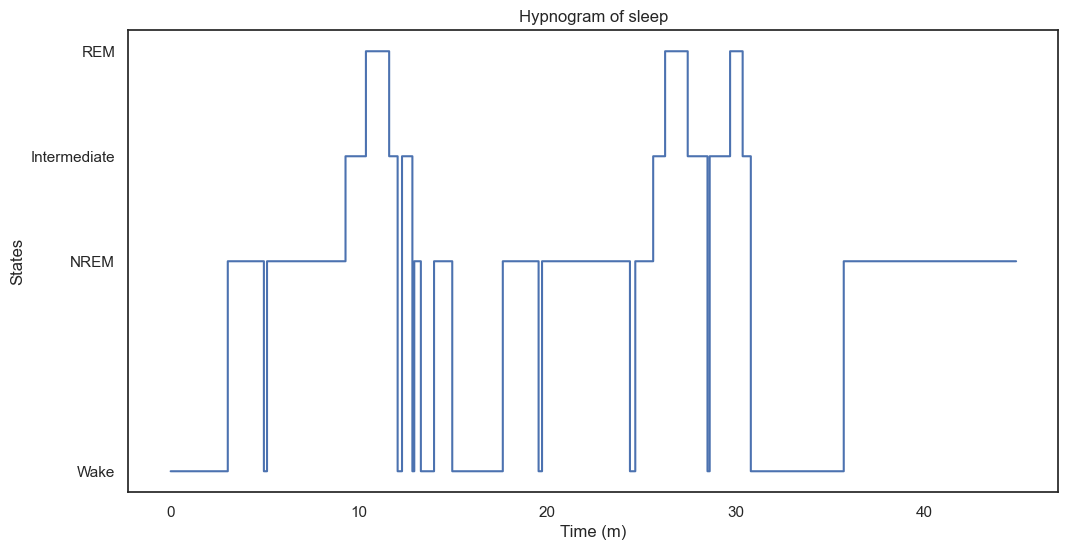

In [5]:
lfpHPC, hypno, fs = get_data(path_to_hpc, path_to_states)
lfpPFC, hypno_pfc, fs = get_data2(path_to_pfc, path_to_states)
plot_hypnogram(hypno)

In [6]:
np.unique(hypno)

array([1, 3, 4, 5], dtype=uint8)

In [7]:
def extract_pt_intervals(lfpHPC, hypno, fs=2500):
    targetFs = 2500
    n_down = fs / targetFs
    start, end = get_start_end(hypno=hypno, sleep_state_id=5)
    rem_interval = nap.IntervalSet(start=start, end=end)
    fs = int(n_down * targetFs)
    t = np.arange(0, len(lfpHPC) / fs, 1 / fs)
    lfp = nap.TsdFrame(t=t, d=lfpHPC, columns=['HPC'])

    # Detect phasic intervals
    lfpHPC_down = preprocess(lfpHPC, n_down)
    phREM = detect_phasic(lfpHPC_down, hypno, targetFs)

    # Create phasic REM IntervalSet
    start, end = [], []
    for rem_idx in phREM:
        for s, e in phREM[rem_idx]:
            start.append(s / targetFs)
            end.append(e / targetFs)
    # Apply a 900 ms duration threshold to phasic intervals
    phasic_interval = nap.IntervalSet(start, end)
    min_duration1 = 0.9  # 900 ms in seconds
    durations1 = phasic_interval['end'] - phasic_interval['start']
    valid_intervals1 = durations1 >= min_duration1
    phasic_interval = nap.IntervalSet(phasic_interval['start'][valid_intervals1], phasic_interval['end'][valid_intervals1])

    # Calculate tonic intervals
    tonic_interval = rem_interval.set_diff(phasic_interval)
    print(f'Number of detected Tonic intervals:{len(tonic_interval)}')
    # Apply a 100 ms duration threshold to tonic intervals
    min_duration = 0.1  # 100 ms in seconds
    durations = tonic_interval['end'] - tonic_interval['start']
    valid_intervals = durations >= min_duration
    tonic_interval = nap.IntervalSet(tonic_interval['start'][valid_intervals], tonic_interval['end'][valid_intervals])
    print(f'Number of detected Tonic intervals after threshold:{len(tonic_interval)}')
    return phasic_interval, tonic_interval, lfp

In [8]:
t = np.arange(0, len(lfpHPC) / fs, 1 / fs)
phasic_interval, tonic_interval, lfp = extract_pt_intervals(lfpHPC, hypno)

len(phasic_interval)

Number of detected Tonic intervals:6
Number of detected Tonic intervals after threshold:6


3

In [9]:
print([phasic_interval])

[  index    start       end
      0   668.46   672.522
      1  1607.48  1608.65
      2  1631.84  1632.85
shape: (3, 2), time unit: sec.]


In [10]:
print([tonic_interval])

[  index     start      end
      0   623       668.46
      1   672.522   696
      2  1576      1607.48
      3  1608.65   1631.84
      4  1632.85   1647
      5  1783      1822
shape: (6, 2), time unit: sec.]


In [24]:
interval7 = np.arange(1879.0, 1895.49, 4)
interval8 = np.arange(1897.76, 1942.0, 4)
print(interval7)
print(interval8)

[1879. 1883. 1887. 1891. 1895.]
[1897.76 1901.76 1905.76 1909.76 1913.76 1917.76 1921.76 1925.76 1929.76
 1933.76 1937.76 1941.76]


In [11]:
tonic_time = np.array([
    [623.00, 627.00],
    [627.00, 631.00],
    [631.00, 635.00],
    [635.00, 639.00],
    [639.00, 643.00],
    [643.00, 647.00],
    [647.00, 651.00],
    [651.00, 655.00],
    [655.00, 659.00],
    [659.00, 663.00],
    [663.00, 668.46],

    [672.522, 676.522],
    [676.522, 680.522],
    [680.522, 684.522],
    [684.522, 688.522],
    [688.522, 692.522],
    [692.522, 696.000],

    [1576.00, 1580.00],
    [1580.00, 1584.00],
    [1584.00, 1588.00],
    [1588.00, 1592.00],
    [1592.00, 1596.00],
    [1596.00, 1600.00],
    [1600.00, 1604.00],
    [1604.00, 1607.48],

    [1608.65, 1612.65],
    [1612.65, 1616.65],
    [1616.65, 1620.65],
    [1620.65, 1624.65],
    [1624.65, 1628.65],
    [1628.65, 1631.84],

    [1632.85, 1636.85],
    [1636.85, 1640.85],
    [1640.85, 1644.85],
    [1644.85, 1647.00],

    [1783.00, 1787.00],
    [1787.00, 1791.00],
    [1791.00, 1795.00],
    [1795.00, 1799.00],
    [1799.00, 1803.00],
    [1803.00, 1807.00],
    [1807.00, 1811.00],
    [1811.00, 1815.00],
    [1815.00, 1819.00],
    [1819.00, 1822.00]
])


print(tonic_time.size)

90


In [12]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [13]:
for i in range(len(tonic_time)):
    tonic_interval_low = find_nearest(t, tonic_time[i,0])
    tonic_index_low = np.where(t == tonic_interval_low)[0]
    
    tonic_interval_high = find_nearest(t, tonic_time[i,1])
    tonic_index_high = np.where(t == tonic_interval_high)[0]

    signal1 = (lfpHPC[tonic_index_low[0]:tonic_index_high[0]]).T
    print(signal1.size)

10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
13650
10000
10000
10000
10000
10000
8695
10000
10000
10000
10000
10000
10000
10000
8700
10000
10000
10000
10000
10000
7975
10000
10000
10000
5375
10000
10000
10000
10000
10000
10000
10000
10000
10000
7500


In [14]:
highsize = 13650

## Comparison

## Coherence

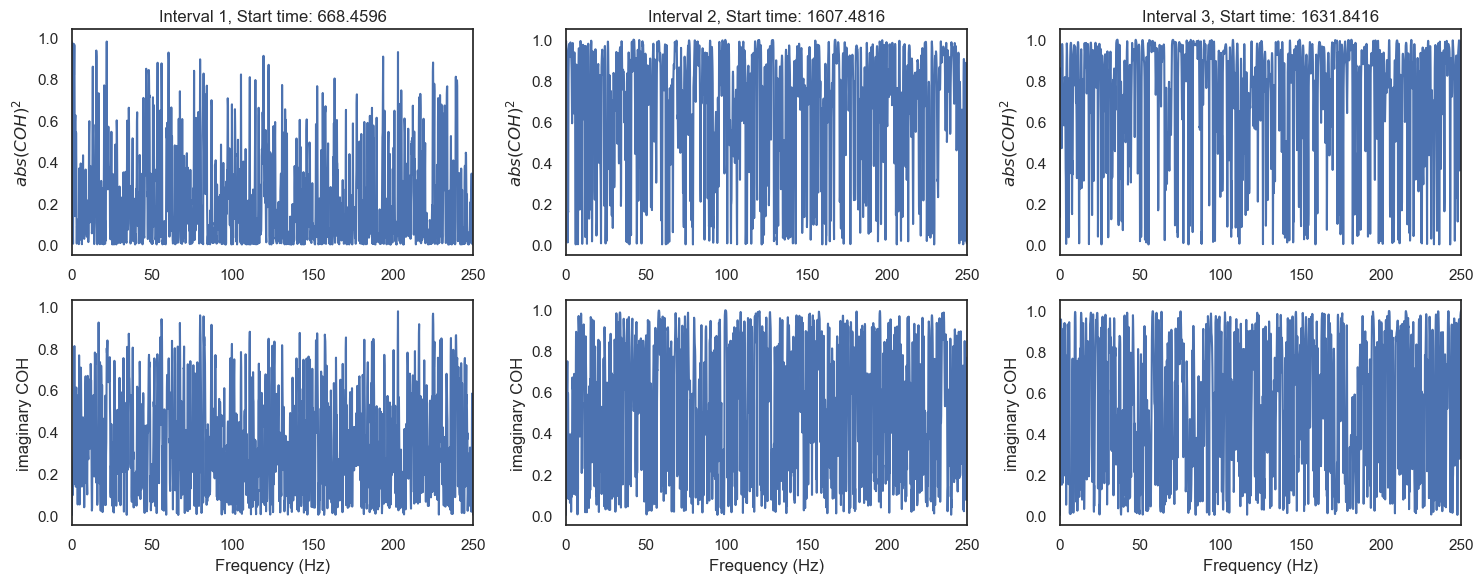

In [15]:
time_halfbandwidth_product = 2 #test value from example
sampling_frequency = 2500
frequency_set = []
coh_set = []
icoh_set = []

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 6), constrained_layout=True)

for i in range(len(phasic_interval)):
    interval_low = find_nearest(t, phasic_interval[i,0])
    index_low = np.where(t == interval_low)[0]
    
    interval_high = find_nearest(t, phasic_interval[i,1])
    index_high = np.where(t == interval_high)[0]

    signal1 = (lfpHPC[index_low[0]:index_high[0]]).T
    signal1_padded = np.pad(signal1, pad_width = (highsize - len(signal1)), mode = 'constant', constant_values = 0)
    signal2 = (lfpPFC[index_low[0]:index_high[0]]).T
    signal2_padded = np.pad(signal2, pad_width = (highsize - len(signal2)), mode = 'constant', constant_values = 0)

    signal_tot = np.vstack((signal1_padded.T,signal2_padded.T)).T
    signal_tot.shape

    time = t[index_low[0]:index_high[0]]
    time_padded = np.pad(time, pad_width = (highsize - len(time)), mode = 'constant', constant_values = 0)

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    
    frequency_set = np.append(frequency_set,connectivity.frequencies)
    coh_set = np.append(coh_set, np.abs((connectivity.coherence_magnitude()[..., 0, 1].squeeze())**2))
    icoh_set = np.append(icoh_set, connectivity.imaginary_coherence()[..., 0, 1].squeeze())
    
    axes[0,i].plot(
        connectivity.frequencies, np.abs((connectivity.coherence_magnitude()[..., 0, 1].squeeze())**2)
    )
    #axes[0].set_xlim((0, multitaper.nyquist_frequency))
    axes[0,i].set_xlim((0, 250))
    axes[0,i].set_title(f"Interval {i+1}, Start time: {phasic_interval[i,0]}")
    #axes[0, i].set_xlabel('Frequency (Hz)')
    axes[0,i].set_ylabel('$abs(COH)^2$')

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    axes[1,i].plot(
        connectivity.frequencies, connectivity.imaginary_coherence()[..., 0, 1].squeeze()
    )
    #axes[1,i].set_xlim((0, multitaper.nyquist_frequency))
    axes[1,i].set_xlim((0, 250))
    #axes[1].set_title(f"Interval {i+1}")
    axes[1,i].set_xlabel('Frequency (Hz)')
    axes[1,i].set_ylabel('imaginary COH')

fig.set_layout_engine(layout='tight')
fig.savefig("phasic_coh_R1T4_HC.png")

mean coh: 0.6309089500531947 +/- 0.0017774148338104304
mean icoh: 0.4339139158152554 +/- 0.0013668337530862778
mean coh: 0.5591034759251955 +/- 0.0018879169533396866
mean icoh: 0.5077898495505927 +/- 0.0016065437416960416
mean coh: 0.5989751173700423 +/- 0.0018704867904787176
mean icoh: 0.5379865439693902 +/- 0.00160338997624718
mean coh: 0.5854727834392921 +/- 0.0018517207947092039
mean icoh: 0.5073982080634489 +/- 0.0016178020213184884


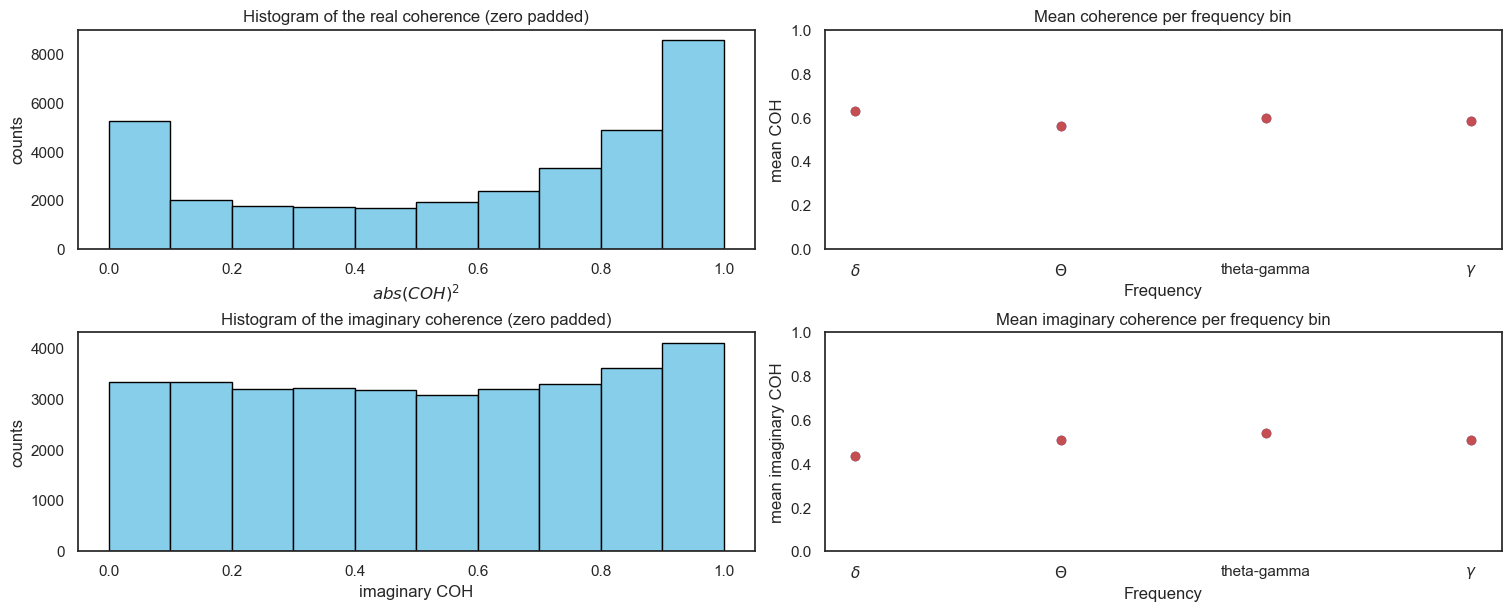

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6), constrained_layout=True)

axes[0,0].hist(coh_set, bins=10, color='skyblue', edgecolor='black')
axes[0,0].set_xlabel('$abs(COH)^2$')
axes[0,0].set_ylabel('counts')
axes[0,0].set_title('Histogram of the real coherence (zero padded)')

axes[1,0].hist(icoh_set, bins=10, color='skyblue', edgecolor='black')
axes[1,0].set_xlabel('imaginary COH')
axes[1,0].set_ylabel('counts')
axes[1,0].set_title('Histogram of the imaginary coherence (zero padded)')


mean = binned_statistic(frequency_set, coh_set, bins=[1, 5, 13, 20, 140], statistic='mean')
stdev = binned_statistic(frequency_set, coh_set, bins=[1, 5, 13, 20, 140], statistic='std')
n = len(coh_set)

bin_edges = mean.bin_edges
bin_means = mean.statistic
bin_stdev = stdev.statistic
error = bin_stdev/(np.sqrt(n))

frequency_type = ['$\delta$', '$\Theta$', 'theta-gamma', '$\gamma$']
freq_middle = [3, 8, 16, 80]

axes[0,1].scatter(frequency_type, bin_means)
axes[0,1].errorbar(frequency_type, bin_means, yerr=error, fmt="o", color="r")
axes[0,1].set_ylim(0,1)
#axes[2].set_xlim(0,140)
axes[0,1].set_ylabel('mean COH')
axes[0,1].set_xlabel('Frequency')
axes[0,1].set_title('Mean coherence per frequency bin')

mean2 = binned_statistic(frequency_set, icoh_set, bins=[1, 5, 13, 20, 140], statistic='mean')
stdev2 = binned_statistic(frequency_set, icoh_set, bins=[1, 5, 13, 20, 140], statistic='std')
n2 = len(icoh_set)

bin_edges2 = mean2.bin_edges
bin_means2 = mean2.statistic
bin_stdev2 = stdev2.statistic
error2 = bin_stdev2/(np.sqrt(n2))

axes[1,1].scatter(frequency_type, bin_means2)
axes[1,1].errorbar(frequency_type, bin_means2, yerr=error2, fmt="o", color="r")
axes[1,1].set_ylim(0,1)
#axes[2].set_xlim(0,140)
axes[1,1].set_ylabel('mean imaginary COH')
axes[1,1].set_xlabel('Frequency')
axes[1,1].set_title('Mean imaginary coherence per frequency bin')

#revbinnedstars, edges, _ = binned_statistic(rev_count, stars, 'mean', bins=10)
#revbin = edges[:-1]

for i in range(len(bin_means)):
    print('mean coh:', bin_means[i], '+/-', error[i])
    print('mean icoh:', bin_means2[i], '+/-', error2[i])

mean_coh_phasic = bin_means
mean_icoh_phasic = bin_means2
SEM_coh_phasic = error
SEM_icoh_phasic = error2

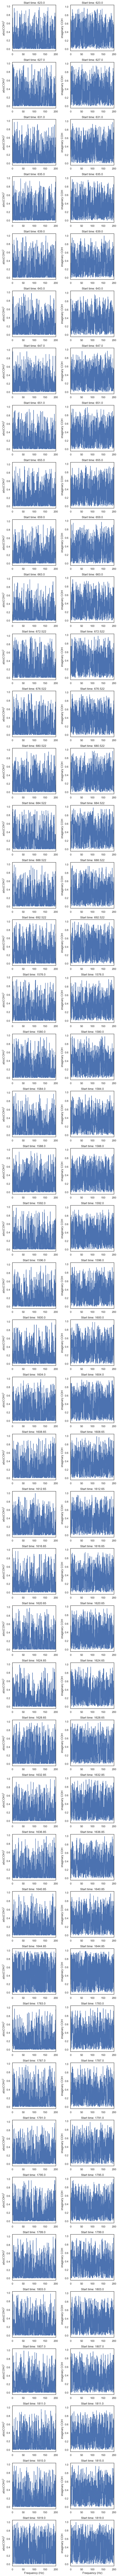

In [17]:
output_folder = "C:/Users/ejsev/Downloads/sleep scoring/outputs/Plots_OS_Basic"
time_halfbandwidth_product = 2 #test value from example
sampling_frequency = 2500
frequency_set = []
coh_set = []
icoh_set = []

fig, axes = plt.subplots(nrows=len(tonic_time), ncols=2, figsize=(7, 150), constrained_layout=True)

for i in range(len(tonic_time)):
    tonic_interval_low = find_nearest(t, tonic_time[i,0])
    tonic_index_low = np.where(t == tonic_interval_low)[0]
    
    tonic_interval_high = find_nearest(t, tonic_time[i,1])
    tonic_index_high = np.where(t == tonic_interval_high)[0]

    signal1 = (lfpHPC[tonic_index_low[0]:tonic_index_high[0]]).T
    signal1_padded = np.pad(signal1, pad_width = (highsize - len(signal1)), mode = 'constant', constant_values = 0)
    signal2 = (lfpPFC[tonic_index_low[0]:tonic_index_high[0]]).T
    signal2_padded = np.pad(signal2, pad_width = (highsize - len(signal2)), mode = 'constant', constant_values = 0)

    signal_tot = np.vstack((signal1_padded.T,signal2_padded.T)).T
    signal_tot.shape

    time = t[index_low[0]:index_high[0]]
    time_padded = np.pad(time, pad_width = (highsize - len(time)), mode = 'constant', constant_values = 0)

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    
    frequency_set = np.append(frequency_set,connectivity.frequencies)
    coh_set = np.append(coh_set, np.abs((connectivity.coherence_magnitude()[..., 0, 1].squeeze())**2))
    
    axes[i, 0].plot(
        connectivity.frequencies, np.abs((connectivity.coherence_magnitude()[..., 0, 1].squeeze())**2)
    )
    #axes[0, i].set_xlim((0, multitaper.nyquist_frequency))
    axes[i, 0].set_xlim((0, 200))
    #axes[i, 0].set_title(f"Interval {i+1}, real COH")
    axes[i,0].set_title(f"Start time: {tonic_time[i,0]}")
    #axes[i, 0].set_xlabel('Frequency (Hz)')
    axes[i, 0].set_ylabel('$abs(COH)^2$')

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    icoh_set = np.append(icoh_set, connectivity.imaginary_coherence()[..., 0, 1].squeeze())
    
    axes[i, 1].plot(
        connectivity.frequencies, connectivity.imaginary_coherence()[..., 0, 1].squeeze()
    )
    #axes[1, i].set_xlim((0, multitaper.nyquist_frequency))
    axes[i, 1].set_xlim((0, 200))
    #axes[i, 1].set_title(f"Interval {i+1}, imaginary COH")
    axes[i,1].set_title(f"Start time: {tonic_time[i,0]}")
    #axes[i, 1].set_xlabel('Frequency (Hz)')
    axes[i, 1].set_ylabel('imaginary COH')

axes[len(tonic_time)-1,0].set_xlabel('Frequency (Hz)')
axes[len(tonic_time)-1,1].set_xlabel('Frequency (Hz)')

fig.set_layout_engine(layout='tight')
fig.savefig("tonic_coh_R1T4_HC.png")

mean coh: 0.22804146167558267 +/- 0.0003746158395764107
mean coh: 0.26564189501552116 +/- 0.00039966791527520066
mean coh: 0.23084304705706152 +/- 0.0003826237501442886
mean coh: 0.21600643892437155 +/- 0.0003609955659540671
mean icoh: 0.3522814387531297 +/- 0.0003728976180336886
mean icoh: 0.43412374400487336 +/- 0.00042557888686158354
mean icoh: 0.35802324536924107 +/- 0.00037543832202559957
mean icoh: 0.3577575564860173 +/- 0.00037372926422847243


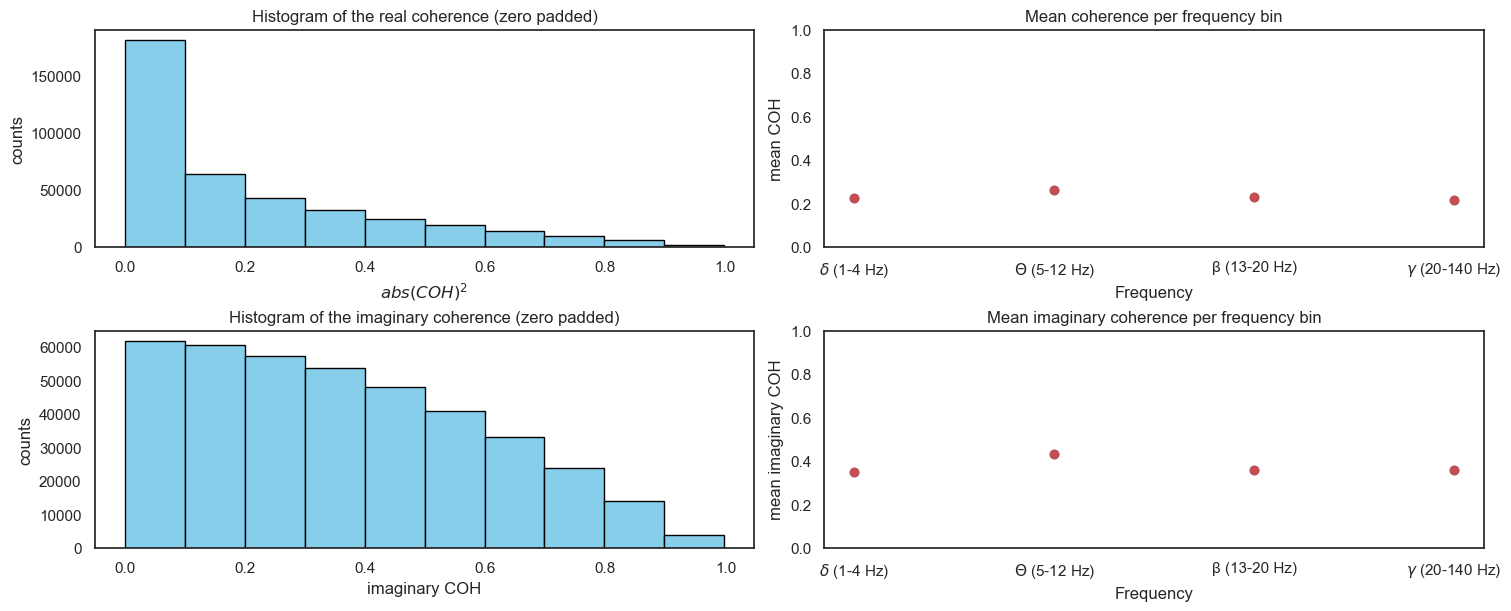

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6), constrained_layout=True)

axes[0,0].hist(coh_set, bins=10, color='skyblue', edgecolor='black')
axes[0,0].set_xlabel('$abs(COH)^2$')
axes[0,0].set_ylabel('counts')
axes[0,0].set_title('Histogram of the real coherence (zero padded)')

axes[1,0].hist(icoh_set, bins=10, color='skyblue', edgecolor='black')
axes[1,0].set_xlabel('imaginary COH')
axes[1,0].set_ylabel('counts')
axes[1,0].set_title('Histogram of the imaginary coherence (zero padded)')


mean = binned_statistic(frequency_set, coh_set, bins=[1, 5, 13, 20, 140], statistic='mean')
stdev = binned_statistic(frequency_set, coh_set, bins=[1, 5, 13, 20, 140], statistic='std')
n = len(coh_set)

bin_edges = mean.bin_edges
bin_means = mean.statistic
bin_stdev = stdev.statistic
error = bin_stdev/(np.sqrt(n))

frequency_type = ['$\delta$ (1-4 Hz)', '$\Theta$ (5-12 Hz)', 'β (13-20 Hz)', '$\gamma$ (20-140 Hz)']
freq_middle = [3, 8, 16, 80]

axes[0,1].scatter(frequency_type, bin_means)
axes[0,1].errorbar(frequency_type, bin_means, yerr=error, fmt="o", color="r")
axes[0,1].set_ylim(0,1)
#axes[2].set_xlim(0,140)
axes[0,1].set_ylabel('mean COH')
axes[0,1].set_xlabel('Frequency')
axes[0,1].set_title('Mean coherence per frequency bin')

mean2 = binned_statistic(frequency_set, icoh_set, bins=[1, 5, 13, 20, 140], statistic='mean')
stdev2 = binned_statistic(frequency_set, icoh_set, bins=[1, 5, 13, 20, 140], statistic='std')
n2 = len(icoh_set)

bin_edges2 = mean2.bin_edges
bin_means2 = mean2.statistic
bin_stdev2 = stdev2.statistic
error2 = bin_stdev2/(np.sqrt(n2))

axes[1,1].scatter(frequency_type, bin_means2)
axes[1,1].errorbar(frequency_type, bin_means2, yerr=error2, fmt="o", color="r")
axes[1,1].set_ylim(0,1)
#axes[2].set_xlim(0,140)
axes[1,1].set_ylabel('mean imaginary COH')
axes[1,1].set_xlabel('Frequency')
axes[1,1].set_title('Mean imaginary coherence per frequency bin')

#revbinnedstars, edges, _ = binned_statistic(rev_count, stars, 'mean', bins=10)
#revbin = edges[:-1]

for i in range(len(bin_means)):
    print('mean coh:', bin_means[i], '+/-', error[i])

for i in range(len(bin_means)):
    print('mean icoh:', bin_means2[i], '+/-', error2[i])

mean_coh_tonic = bin_means
mean_icoh_tonic = bin_means2
SEM_coh_tonic = error
SEM_icoh_tonic = error2

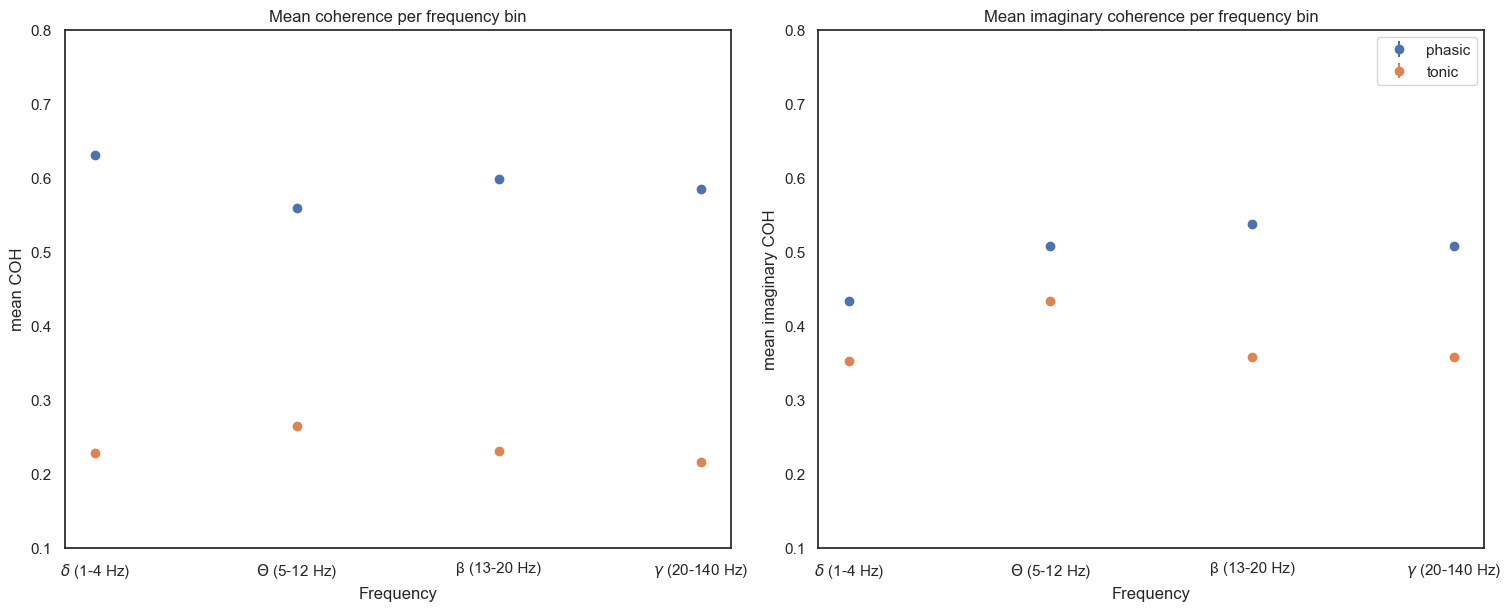

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), constrained_layout=True)
axes[0].errorbar(frequency_type, mean_coh_phasic, yerr=SEM_coh_phasic, fmt="o", label='phasic')
axes[0].errorbar(frequency_type, mean_coh_tonic, yerr=SEM_coh_tonic, fmt="o", label='tonic')
axes[0].set_ylim(0.1,0.8)
#axes[2].set_xlim(0,140)
axes[0].set_ylabel('mean COH')
axes[0].set_xlabel('Frequency')
axes[0].set_title('Mean coherence per frequency bin')

axes[1].errorbar(frequency_type, mean_icoh_phasic, yerr=SEM_icoh_phasic, fmt="o", label='phasic')
axes[1].errorbar(frequency_type, mean_icoh_tonic, yerr=SEM_icoh_tonic, fmt="o", label='tonic')
axes[1].set_ylim(0.1,0.8)
#axes[2].set_xlim(0,140)
axes[1].set_ylabel('mean imaginary COH')
axes[1].set_xlabel('Frequency')
axes[1].set_title('Mean imaginary coherence per frequency bin')
plt.legend()

## Phase lag index

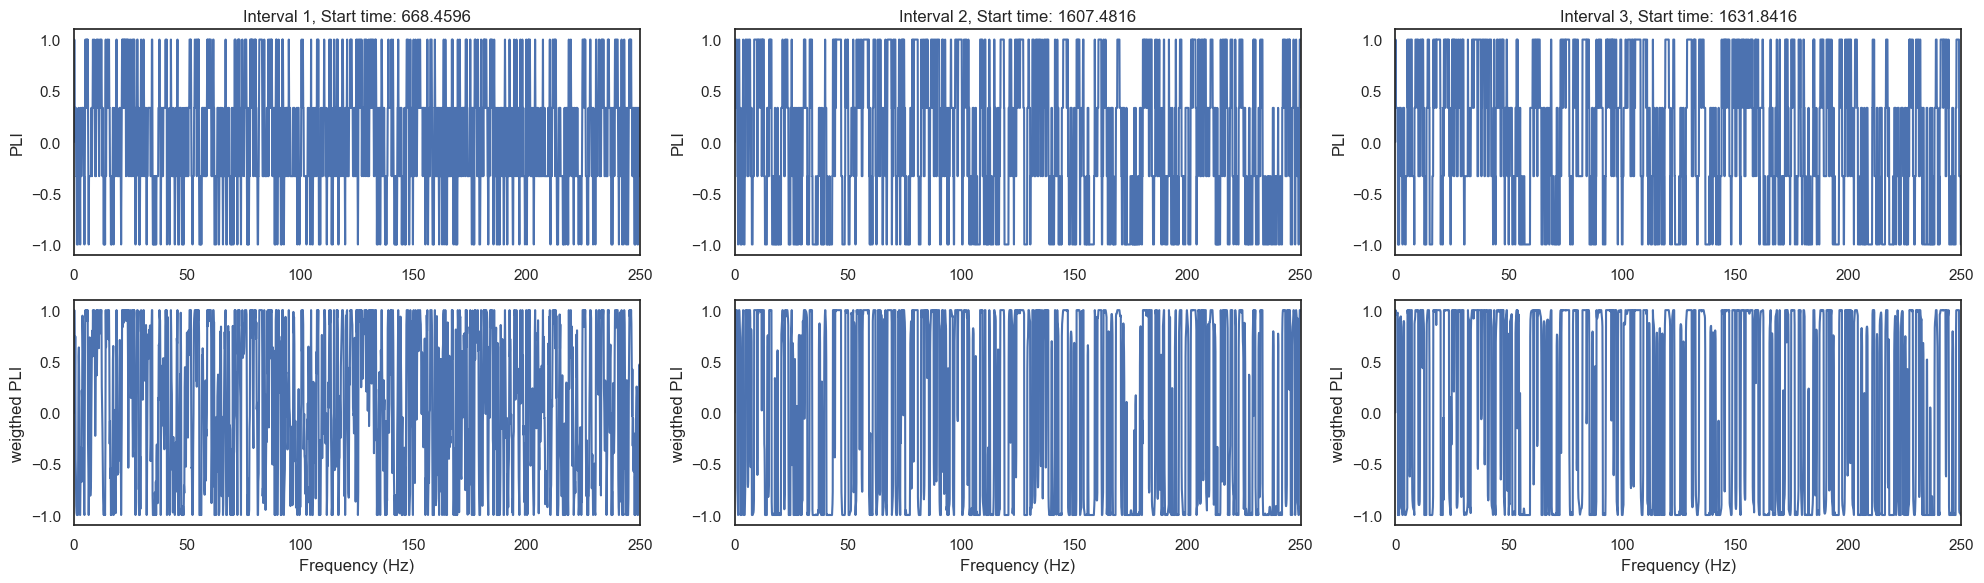

In [20]:
time_halfbandwidth_product = 2 #test value from example
sampling_frequency = 2500
frequency_set = []
pli_set = []
wpli_set = []

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 6), constrained_layout=True)

for i in range(len(phasic_interval)):
    interval_low = find_nearest(t, phasic_interval[i,0])
    index_low = np.where(t == interval_low)[0]
    
    interval_high = find_nearest(t, phasic_interval[i,1])
    index_high = np.where(t == interval_high)[0]

    signal1 = (lfpHPC[index_low[0]:index_high[0]]).T
    signal1_padded = np.pad(signal1, pad_width = (highsize - len(signal1)), mode = 'constant', constant_values = 0)
    signal2 = (lfpPFC[index_low[0]:index_high[0]]).T
    signal2_padded = np.pad(signal2, pad_width = (highsize - len(signal2)), mode = 'constant', constant_values = 0)

    signal_tot = np.vstack((signal1_padded.T,signal2_padded.T)).T
    signal_tot.shape

    time = t[index_low[0]:index_high[0]]
    time_padded = np.pad(time, pad_width = (highsize - len(time)), mode = 'constant', constant_values = 0)

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    
    frequency_set = np.append(frequency_set,connectivity.frequencies)
    pli_set = np.append(pli_set, connectivity.phase_lag_index()[..., 0, 1].squeeze())
    wpli_set = np.append(wpli_set, connectivity.weighted_phase_lag_index()[..., 0, 1].squeeze())
    
    axes[0,i].plot(
        connectivity.frequencies, connectivity.phase_lag_index()[..., 0, 1].squeeze()
    )
    #axes[0, i].set_xlim((0, multitaper.nyquist_frequency))
    axes[0,i].set_xlim((0, 250))
    axes[0,i].set_title(f"Interval {i+1}, Start time: {phasic_interval[i,0]}")
    #axes[0, i].set_xlabel('Frequency (Hz)')
    axes[0,i].set_ylabel('PLI')

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    axes[1,i].plot(
        connectivity.frequencies, connectivity.weighted_phase_lag_index()[..., 0, 1].squeeze(),
    )
    #axes[1, i].set_xlim((0, multitaper.nyquist_frequency))
    axes[1,i].set_xlim((0, 250))
    #axes[1, i].set_title(f"Interval {i+1}")
    axes[1,i].set_xlabel('Frequency (Hz)')
    axes[1,i].set_ylabel('weigthed PLI')

fig.set_layout_engine(layout='tight')
fig.savefig("phasic_pli_R1T4_HC.png")

mean pli: -0.17901234567901228 +/- 0.003238877329795191
mean pli: 0.36150234741784026 +/- 0.003301493025312554
mean pli: -0.04255319148936173 +/- 0.004206760773056333
mean pli: 0.11298026998961569 +/- 0.003777043829370749
mean wpli: -0.1831757561431895 +/- 0.004748707487568297
mean wpli: 0.41603217924757463 +/- 0.004267524782306302
mean wpli: -0.07098324356447637 +/- 0.004881019096427834
mean wpli: 0.1404581071234064 +/- 0.0047484390694286956


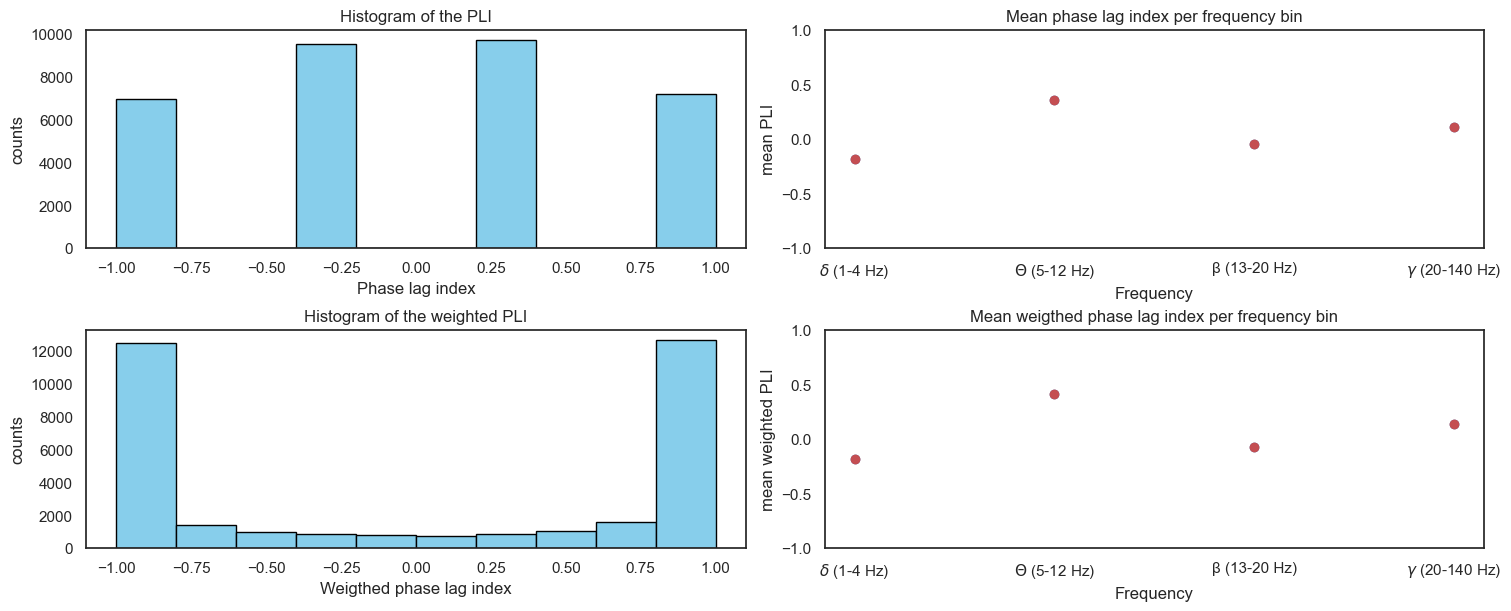

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6), constrained_layout=True)

axes[0,0].hist(pli_set, bins=10, color='skyblue', edgecolor='black')
axes[0,0].set_xlabel('Phase lag index')
axes[0,0].set_ylabel('counts')
axes[0,0].set_title('Histogram of the PLI')

axes[1,0].hist(wpli_set, bins=10, color='skyblue', edgecolor='black')
axes[1,0].set_xlabel('Weigthed phase lag index')
axes[1,0].set_ylabel('counts')
axes[1,0].set_title('Histogram of the weighted PLI')

mean = binned_statistic(frequency_set, (pli_set), bins=[1, 5, 13, 20, 140], statistic='mean')
stdev = binned_statistic(frequency_set, (pli_set), bins=[1, 5, 13, 20, 140], statistic='std')
n = len(pli_set)

bin_edges = mean.bin_edges
bin_means = mean.statistic
bin_stdev = stdev.statistic
error = bin_stdev/(np.sqrt(n))

frequency_type = ['$\delta$ (1-4 Hz)', '$\Theta$ (5-12 Hz)', 'β (13-20 Hz)', '$\gamma$ (20-140 Hz)']
freq_middle = [3, 8, 16, 80]

axes[0,1].scatter(frequency_type, bin_means)
axes[0,1].errorbar(frequency_type, bin_means, yerr=error, fmt="o", color="r")
axes[0,1].set_ylim(-1,1)
#axes[2].set_xlim(0,140)
axes[0,1].set_ylabel('mean PLI')
axes[0,1].set_xlabel('Frequency')
axes[0,1].set_title('Mean phase lag index per frequency bin')

mean2 = binned_statistic(frequency_set, (wpli_set), bins=[1, 5, 13, 20, 140], statistic='mean')
stdev2 = binned_statistic(frequency_set, (wpli_set), bins=[1, 5, 13, 20, 140], statistic='std')

bin_edges2 = mean2.bin_edges
bin_means2 = mean2.statistic
bin_stdev2 = stdev2.statistic
error2 = bin_stdev2/(np.sqrt(n))

axes[1,1].scatter(frequency_type, bin_means2)
axes[1,1].errorbar(frequency_type, bin_means2, yerr=error2, fmt="o", color="r")
axes[1,1].set_ylim(-1,1)
#axes[2].set_xlim(0,140)
axes[1,1].set_ylabel('mean weighted PLI')
axes[1,1].set_xlabel('Frequency')
axes[1,1].set_title('Mean weigthed phase lag index per frequency bin')

for i in range(len(bin_means)):
    print('mean pli:', bin_means[i], '+/-', error[i])

for i in range(len(bin_means)):
    print('mean wpli:', bin_means2[i], '+/-', error2[i])
#revbinnedstars, edges, _ = binned_statistic(rev_count, stars, 'mean', bins=10)
#revbin = edges[:-1]

mean_pli_phasic = bin_means
mean_wpli_phasic = bin_means2
SEM_pli_phasic = error
SEM_wpli_phasic = error2

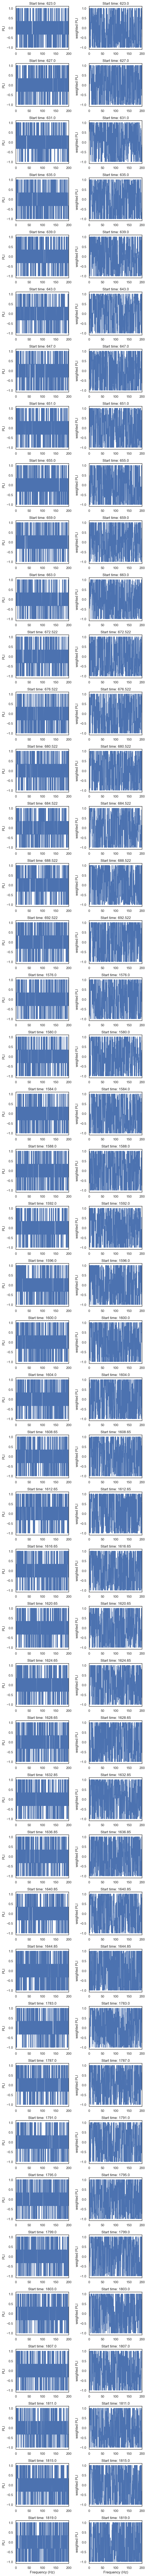

In [22]:
output_folder = "C:/Users/ejsev/Downloads/sleep scoring/outputs/Plots_OS_Basic"
time_halfbandwidth_product = 2 #test value from example
sampling_frequency = 2500
frequency_set = []
pli_set = []
wpli_set = []

fig, axes = plt.subplots(nrows=len(tonic_time), ncols=2, figsize=(7,120), constrained_layout=True)

for i in range(len(tonic_time)):
    tonic_interval_low = find_nearest(t, tonic_time[i,0])
    tonic_index_low = np.where(t == tonic_interval_low)[0]
    
    tonic_interval_high = find_nearest(t, tonic_time[i,1])
    tonic_index_high = np.where(t == tonic_interval_high)[0]

    signal1 = (lfpHPC[tonic_index_low[0]:tonic_index_high[0]]).T
    signal1_padded = np.pad(signal1, pad_width = (highsize - len(signal1)), mode = 'constant', constant_values = 0)
    signal2 = (lfpPFC[tonic_index_low[0]:tonic_index_high[0]]).T
    signal2_padded = np.pad(signal2, pad_width = (highsize - len(signal2)), mode = 'constant', constant_values = 0)

    signal_tot = np.vstack((signal1_padded.T,signal2_padded.T)).T
    signal_tot.shape

    time = t[index_low[0]:index_high[0]]
    time_padded = np.pad(time, pad_width = (highsize - len(time)), mode = 'constant', constant_values = 0)

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    
    frequency_set = np.append(frequency_set,connectivity.frequencies)
    pli_set = np.append(pli_set, connectivity.phase_lag_index()[..., 0, 1].squeeze())
    
    axes[i, 0].plot(
        connectivity.frequencies, connectivity.phase_lag_index()[..., 0, 1].squeeze()
    )
    #axes[0, i].set_xlim((0, multitaper.nyquist_frequency))
    axes[i, 0].set_xlim((0, 200))
    #axes[i, 0].set_title(f"Interval {i+1}, real COH")
    axes[i, 0].set_title(f"Start time: {tonic_time[i,0]}")
    #axes[i, 0].set_xlabel('Frequency (Hz)')
    axes[i, 0].set_ylabel('PLI')

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    wpli_set = np.append(wpli_set, connectivity.weighted_phase_lag_index()[..., 0, 1].squeeze())
    axes[i, 1].plot(
        connectivity.frequencies, connectivity.weighted_phase_lag_index()[..., 0, 1].squeeze()
    )
    #axes[1, i].set_xlim((0, multitaper.nyquist_frequency))
    axes[i, 1].set_xlim((0, 200))
    #axes[i, 1].set_title(f"Interval {i+1}, imaginary COH")
    axes[i, 1].set_title(f"Start time: {tonic_time[i,0]}")
    #axes[i, 1].set_xlabel('Frequency (Hz)')
    axes[i, 1].set_ylabel('weighted PLI')

axes[len(tonic_time)-1,0].set_xlabel('Frequency (Hz)')
axes[len(tonic_time)-1,1].set_xlabel('Frequency (Hz)')

fig.set_layout_engine(layout='tight')
fig.savefig("tonic_pli_R1T4_HC.png")

mean pli: 0.030112594920136158 +/- 0.0009139011599427135
mean pli: 0.2485276796230855 +/- 0.0009690499569375066
mean pli: 0.04954348151474321 +/- 0.0009187243984199809
mean pli: -0.0005148207289512211 +/- 0.0009310597803051296
mean wpli: 0.05456601315897751 +/- 0.0011397611105571778
mean wpli: 0.3313819722623963 +/- 0.0011278014036806834
mean wpli: 0.09692447204214012 +/- 0.0011464145123200973
mean wpli: -0.0006733415458804313 +/- 0.0011588996433132838


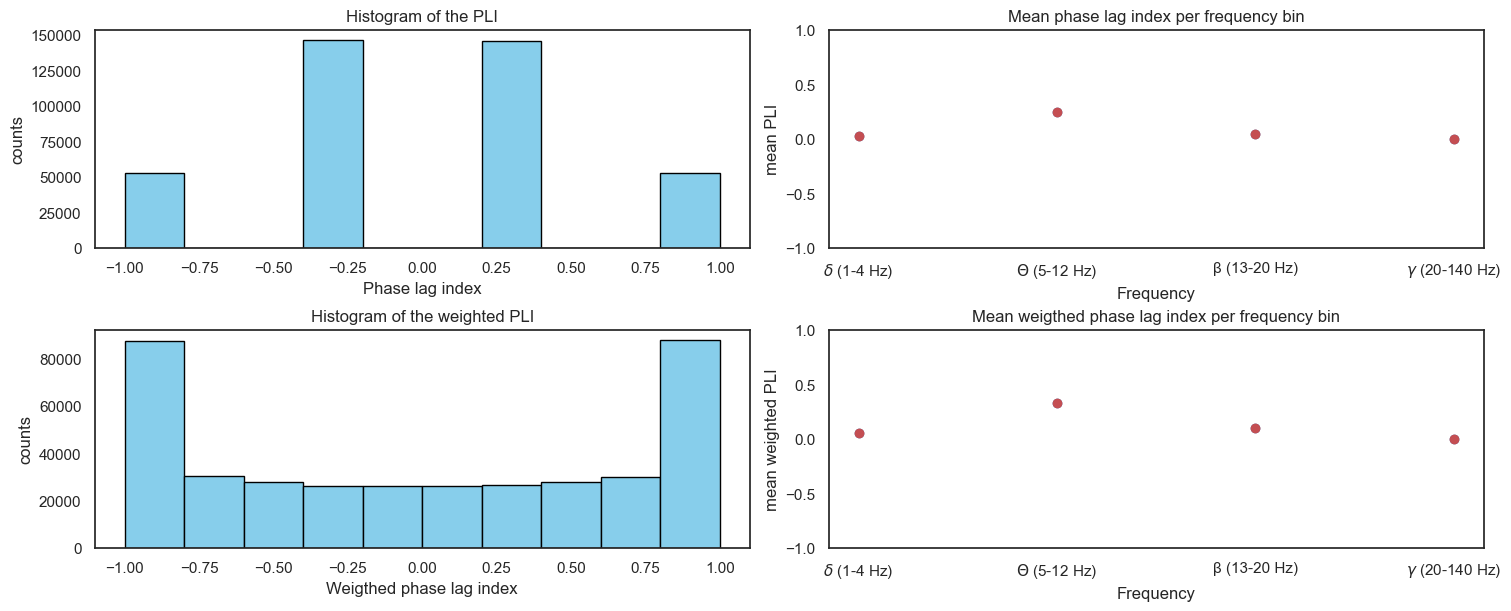

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6), constrained_layout=True)

axes[0,0].hist(pli_set, bins=10, color='skyblue', edgecolor='black')
axes[0,0].set_xlabel('Phase lag index')
axes[0,0].set_ylabel('counts')
axes[0,0].set_title('Histogram of the PLI')

axes[1,0].hist(wpli_set, bins=10, color='skyblue', edgecolor='black')
axes[1,0].set_xlabel('Weigthed phase lag index')
axes[1,0].set_ylabel('counts')
axes[1,0].set_title('Histogram of the weighted PLI')

mean = binned_statistic(frequency_set, (pli_set), bins=[1, 5, 13, 20, 140], statistic='mean')
stdev = binned_statistic(frequency_set, (pli_set), bins=[1, 5, 13, 20, 140], statistic='std')
n = len(pli_set)

bin_edges = mean.bin_edges
bin_means = mean.statistic
bin_stdev = stdev.statistic
error = bin_stdev/(np.sqrt(n))

freq_middle = [3, 8, 16, 80]

axes[0,1].scatter(frequency_type, bin_means)
axes[0,1].errorbar(frequency_type, bin_means, yerr=error, fmt="o", color="r")
axes[0,1].set_ylim(-1,1)
#axes[2].set_xlim(0,140)
axes[0,1].set_ylabel('mean PLI')
axes[0,1].set_xlabel('Frequency')
axes[0,1].set_title('Mean phase lag index per frequency bin')

mean2 = binned_statistic(frequency_set, (wpli_set), bins=[1, 5, 13, 20, 140], statistic='mean')
stdev2 = binned_statistic(frequency_set, (wpli_set), bins=[1, 5, 13, 20, 140], statistic='std')

bin_edges2 = mean2.bin_edges
bin_means2 = mean2.statistic
bin_stdev2 = stdev2.statistic
error2 = bin_stdev2/(np.sqrt(n))

axes[1,1].scatter(frequency_type, bin_means2)
axes[1,1].errorbar(frequency_type, bin_means2, yerr=error2, fmt="o", color="r")
axes[1,1].set_ylim(-1,1)
#axes[2].set_xlim(0,140)
axes[1,1].set_ylabel('mean weighted PLI')
axes[1,1].set_xlabel('Frequency')
axes[1,1].set_title('Mean weigthed phase lag index per frequency bin')

for i in range(len(bin_means)):
    print('mean pli:', bin_means[i], '+/-', error[i])

for i in range(len(bin_means)):
    print('mean wpli:', bin_means2[i], '+/-', error2[i])
#revbinnedstars, edges, _ = binned_statistic(rev_count, stars, 'mean', bins=10)
#revbin = edges[:-1]
mean_pli_tonic = bin_means
mean_wpli_tonic = bin_means2
SEM_pli_tonic = error
SEM_wpli_tonic = error2

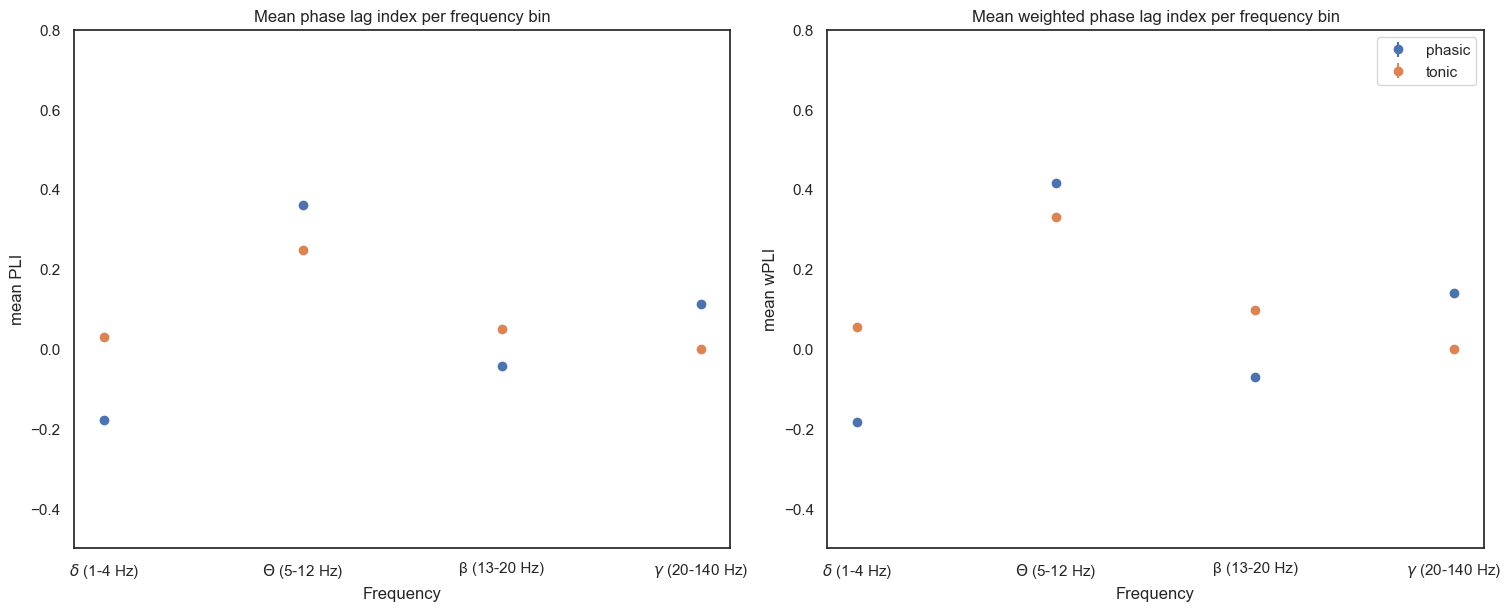

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), constrained_layout=True)
axes[0].errorbar(frequency_type, mean_pli_phasic, yerr=SEM_pli_phasic, fmt="o", label='phasic')
axes[0].errorbar(frequency_type, mean_pli_tonic, yerr=SEM_pli_tonic, fmt="o", label='tonic')
axes[0].set_ylim(-0.5,0.8)
#axes[2].set_xlim(0,140)
axes[0].set_ylabel('mean PLI')
axes[0].set_xlabel('Frequency')
axes[0].set_title('Mean phase lag index per frequency bin')

axes[1].errorbar(frequency_type, mean_wpli_phasic, yerr=SEM_wpli_phasic, fmt="o", label='phasic')
axes[1].errorbar(frequency_type, mean_wpli_tonic, yerr=SEM_wpli_tonic, fmt="o", label='tonic')
axes[1].set_ylim(-0.5,0.8)
#axes[2].set_xlim(0,140)
axes[1].set_ylabel('mean wPLI')
axes[1].set_xlabel('Frequency')
axes[1].set_title('Mean weighted phase lag index per frequency bin')
plt.legend()

## Debiased squared PLI

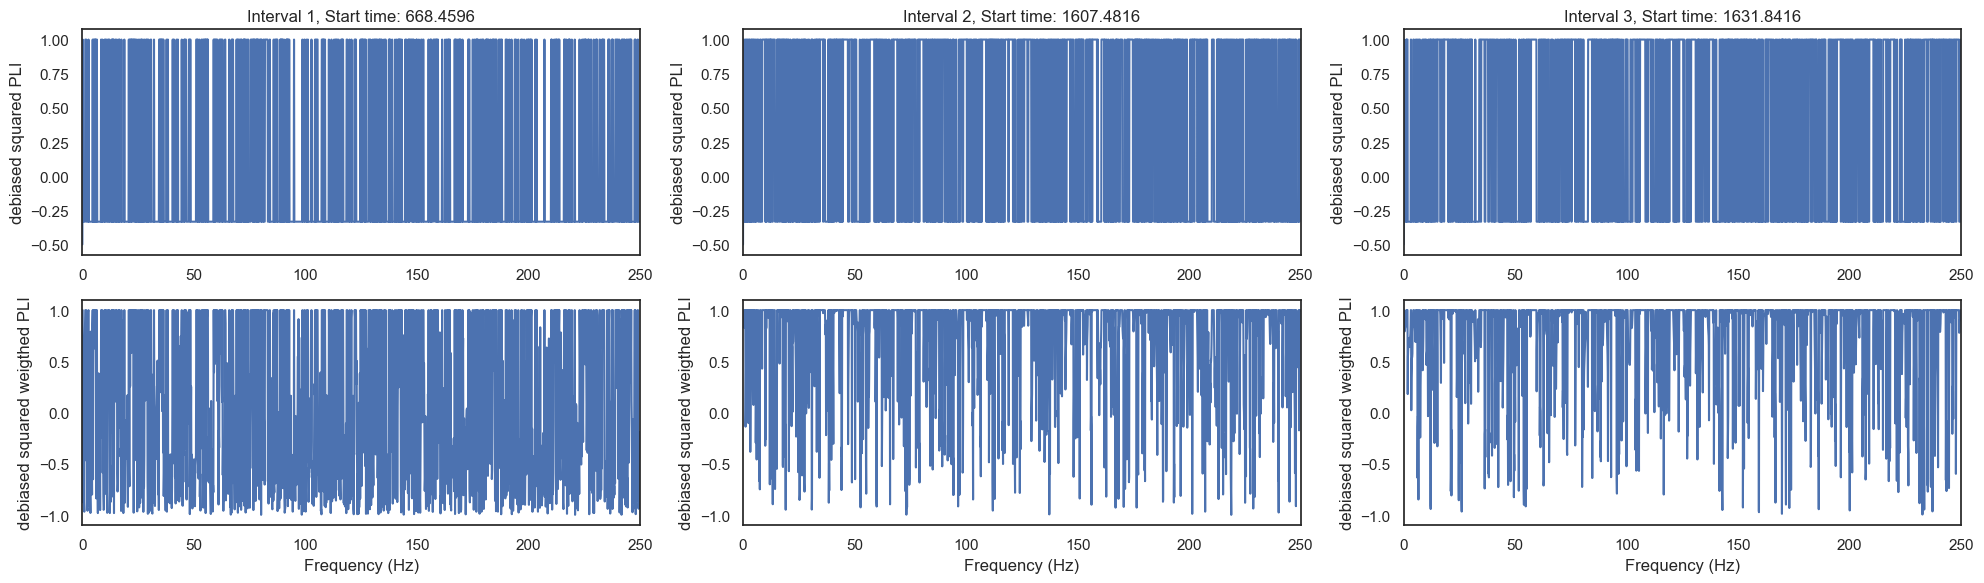

In [25]:
time_halfbandwidth_product = 2 #test value from example
sampling_frequency = 2500
frequency_set = []
dspli_set = []
wdspli_set = []

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 6), constrained_layout=True)

for i in range(len(phasic_interval)):
    interval_low = find_nearest(t, phasic_interval[i,0])
    index_low = np.where(t == interval_low)[0]
    
    interval_high = find_nearest(t, phasic_interval[i,1])
    index_high = np.where(t == interval_high)[0]

    signal1 = (lfpHPC[index_low[0]:index_high[0]]).T
    signal1_padded = np.pad(signal1, pad_width = (highsize - len(signal1)), mode = 'constant', constant_values = 0)
    signal2 = (lfpPFC[index_low[0]:index_high[0]]).T
    signal2_padded = np.pad(signal2, pad_width = (highsize - len(signal2)), mode = 'constant', constant_values = 0)

    signal_tot = np.vstack((signal1_padded.T,signal2_padded.T)).T
    signal_tot.shape

    time = t[index_low[0]:index_high[0]]
    time_padded = np.pad(time, pad_width = (highsize - len(time)), mode = 'constant', constant_values = 0)

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    
    frequency_set = np.append(frequency_set,connectivity.frequencies)
    dspli_set = np.append(dspli_set, connectivity.debiased_squared_phase_lag_index()[..., 0, 1].squeeze())
    wdspli_set = np.append(wdspli_set, connectivity.debiased_squared_weighted_phase_lag_index()[..., 0, 1].squeeze())
    
    axes[0,i].plot(
        connectivity.frequencies, connectivity.debiased_squared_phase_lag_index()[..., 0, 1].squeeze(),
    )
    #axes[0, i].set_xlim((0, multitaper.nyquist_frequency))
    axes[0,i].set_xlim((0, 250))
    axes[0,i].set_title(f"Interval {i+1}, Start time: {phasic_interval[i,0]}")
    #axes[0, i].set_xlabel('Frequency (Hz)')
    axes[0,i].set_ylabel('debiased squared PLI')

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    axes[1,i].plot(
        connectivity.frequencies, connectivity.debiased_squared_weighted_phase_lag_index()[..., 0, 1].squeeze(),
    )
    #axes[1, i].set_xlim((0, multitaper.nyquist_frequency))
    axes[1,i].set_xlim((0, 250))
    #axes[1, i].set_title(f"Interval {i+1}")
    axes[1,i].set_xlabel('Frequency (Hz)')
    axes[1,i].set_ylabel('debiased squared weigthed PLI')

fig.set_layout_engine(layout='tight')
fig.savefig("phasic_dspli_R1T4_HC.png")

mean dspli: 0.07407407407407406 +/- 0.0033592891404522957
mean dspli: 0.2425665101721435 +/- 0.0036123559293219456
mean dspli: 0.3900709219858155 +/- 0.0036330803431325544
mean dspli: 0.23447559709241791 +/- 0.0036059975917875665
mean wdspli: 0.5503443302136117 +/- 0.0030689581300499522
mean wdspli: 0.5472108507414183 +/- 0.0033701131302575566
mean wdspli: 0.5995229215900247 +/- 0.003388790084056564
mean wdspli: 0.5392199904465559 +/- 0.0034391170748726374


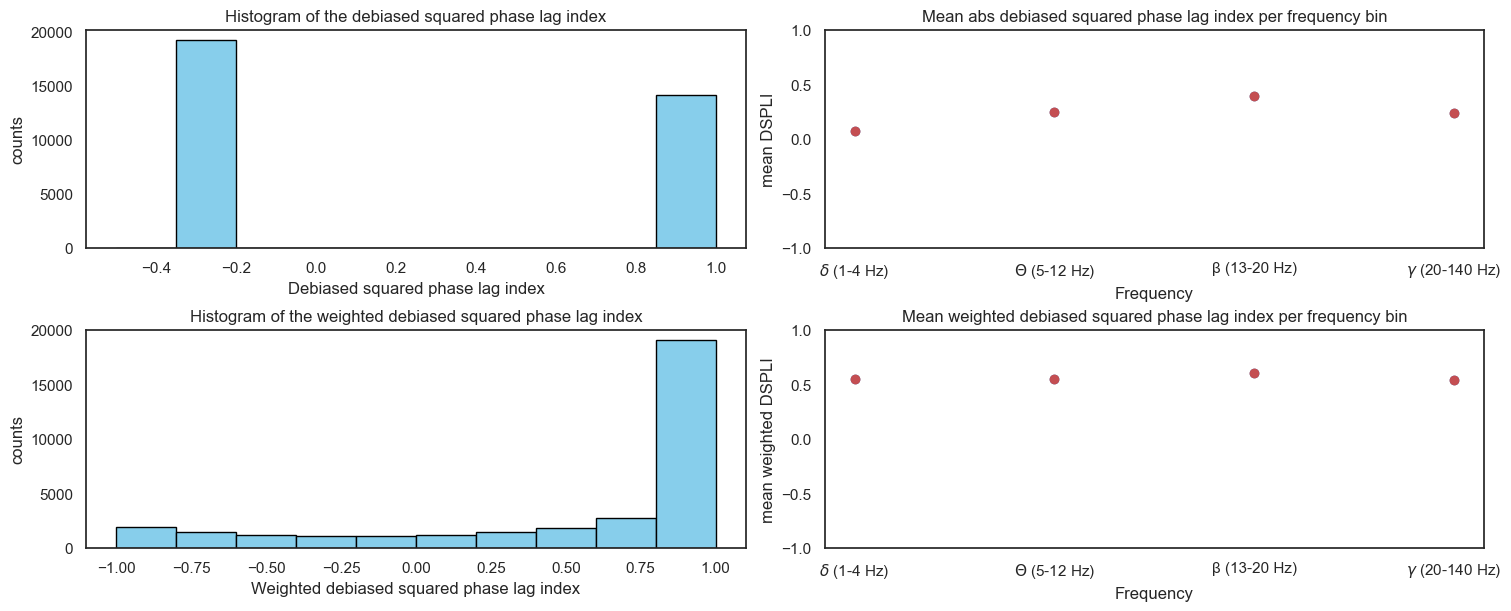

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6), constrained_layout=True)

axes[0,0].hist(dspli_set, bins=10, color='skyblue', edgecolor='black')
axes[0,0].set_xlabel('Debiased squared phase lag index')
axes[0,0].set_ylabel('counts')
axes[0,0].set_title('Histogram of the debiased squared phase lag index')

axes[1,0].hist(wdspli_set, bins=10, color='skyblue', edgecolor='black')
axes[1,0].set_xlabel('Weighted debiased squared phase lag index')
axes[1,0].set_ylabel('counts')
axes[1,0].set_title('Histogram of the weighted debiased squared phase lag index')

mean = binned_statistic(frequency_set, dspli_set, bins=[1, 5, 13, 20, 140], statistic='mean')
stdev = binned_statistic(frequency_set, dspli_set, bins=[1, 5, 13, 20, 140], statistic='std')
n = len(dspli_set)

bin_edges = mean.bin_edges
bin_means = mean.statistic
bin_stdev = stdev.statistic
error = bin_stdev/(np.sqrt(n))

freq_middle = [3, 8, 16, 80]

axes[0,1].scatter(frequency_type, bin_means)
axes[0,1].errorbar(frequency_type, bin_means, yerr=error, fmt="o", color="r")
axes[0,1].set_ylim(-1,1)
#axes[2].set_xlim(0,140)
axes[0,1].set_ylabel('mean DSPLI')
axes[0,1].set_xlabel('Frequency')
axes[0,1].set_title('Mean abs debiased squared phase lag index per frequency bin')

mean2 = binned_statistic(frequency_set, wdspli_set, bins=[1, 5, 13, 20, 140], statistic='mean')
stdev2 = binned_statistic(frequency_set, wdspli_set, bins=[1, 5, 13, 20, 140], statistic='std')

bin_edges2 = mean2.bin_edges
bin_means2 = mean2.statistic
bin_stdev2 = stdev2.statistic
error2 = bin_stdev2/(np.sqrt(n))

axes[1,1].scatter(frequency_type, bin_means2)
axes[1,1].errorbar(frequency_type, bin_means2, yerr=error2, fmt="o", color="r")
axes[1,1].set_ylim(-1,1)
#axes[2].set_xlim(0,140)
axes[1,1].set_ylabel('mean weighted DSPLI')
axes[1,1].set_xlabel('Frequency')
axes[1,1].set_title('Mean weighted debiased squared phase lag index per frequency bin')

for i in range(len(bin_means)):
    print('mean dspli:', bin_means[i], '+/-', error[i])

for i in range(len(bin_means)):
    print('mean wdspli:', bin_means2[i], '+/-', error2[i])
#revbinnedstars, edges, _ = binned_statistic(rev_count, stars, 'mean', bins=10)
#revbin = edges[:-1]

mean_dspli_phasic = bin_means
mean_wdspli_phasic = bin_means2
SEM_dspli_phasic = error
SEM_wdspli_phasic = error2

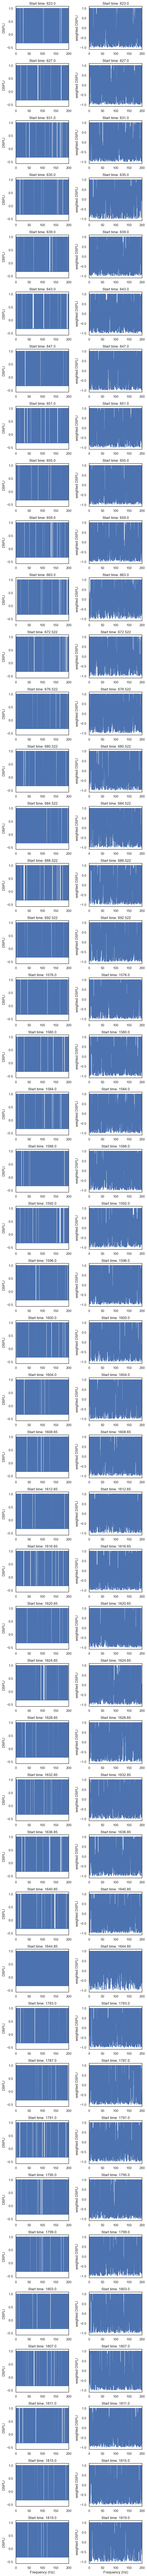

In [27]:
output_folder = "C:/Users/ejsev/Downloads/sleep scoring/outputs/Plots_OS_Basic"
time_halfbandwidth_product = 2 #test value from example
sampling_frequency = 2500
frequency_set = []
frequency_set2 = []
dspli_set = []
wdspli_set = []

fig, axes = plt.subplots(nrows=len(tonic_time), ncols=2, figsize=(7, 120), constrained_layout=True)

for i in range(len(tonic_time)):
    tonic_interval_low = find_nearest(t, tonic_time[i,0])
    tonic_index_low = np.where(t == tonic_interval_low)[0]
    
    tonic_interval_high = find_nearest(t, tonic_time[i,1])
    tonic_index_high = np.where(t == tonic_interval_high)[0]

    signal1 = (lfpHPC[tonic_index_low[0]:tonic_index_high[0]]).T
    signal1_padded = np.pad(signal1, pad_width = (highsize - len(signal1)), mode = 'constant', constant_values = 0)
    signal2 = (lfpPFC[tonic_index_low[0]:tonic_index_high[0]]).T
    signal2_padded = np.pad(signal2, pad_width = (highsize - len(signal2)), mode = 'constant', constant_values = 0)

    signal_tot = np.vstack((signal1_padded.T,signal2_padded.T)).T
    signal_tot.shape

    time = t[index_low[0]:index_high[0]]
    time_padded = np.pad(time, pad_width = (highsize - len(time)), mode = 'constant', constant_values = 0)

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    
    frequency_set = np.append(frequency_set,connectivity.frequencies)
    dspli_set = np.append(dspli_set, connectivity.debiased_squared_phase_lag_index()[..., 0, 1].squeeze())
    
    axes[i, 0].plot(
        connectivity.frequencies, connectivity.debiased_squared_phase_lag_index()[..., 0, 1].squeeze(),
    )
    #axes[0, i].set_xlim((0, multitaper.nyquist_frequency))
    axes[i, 0].set_xlim((0, 200))
    #axes[i, 0].set_title(f"Interval {i+1}, real COH")
    axes[i, 0].set_title(f"Start time: {tonic_time[i,0]}")
    #axes[i, 0].set_xlabel('Frequency (Hz)')
    axes[i, 0].set_ylabel('DSPLI')

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    wdspli_set = np.append(wdspli_set, connectivity.debiased_squared_weighted_phase_lag_index()[..., 0, 1].squeeze())
    frequency_set2 = np.append(frequency_set2,connectivity.frequencies)
    axes[i, 1].plot(
        connectivity.frequencies, connectivity.debiased_squared_weighted_phase_lag_index()[..., 0, 1].squeeze(),
    )
    #axes[1, i].set_xlim((0, multitaper.nyquist_frequency))
    axes[i, 1].set_xlim((0, 200))
    #axes[i, 1].set_title(f"Interval {i+1}, imaginary COH")
    axes[i, 1].set_title(f"Start time: {tonic_time[i,0]}")
    #axes[i, 1].set_xlabel('Frequency (Hz)')
    axes[i, 1].set_ylabel('weighted DSPLI')

axes[len(tonic_time)-1,0].set_xlabel('Frequency (Hz)')
axes[len(tonic_time)-1,1].set_xlabel('Frequency (Hz)')

fig.set_layout_engine(layout='tight')
fig.savefig("tonic_dspli_R1T4_HC.png")

mean dspli: -0.00026184865147953624 +/- 0.0009151473066217092
mean dspli: 0.15299044627666625 +/- 0.0010175888377413035
mean dspli: 0.007334231402484734 +/- 0.0009220030188035819
mean dspli: 0.017268308857529353 +/- 0.0009306574983424641
mean wdspli: 0.020056261490726764 +/- 0.001169848752789191
mean wdspli: 0.18960998452658168 +/- 0.0012146894373127176
mean wdspli: 0.025315352876558034 +/- 0.0011823339589786509
mean wdspli: 0.028476309586832046 +/- 0.0011879953536193548


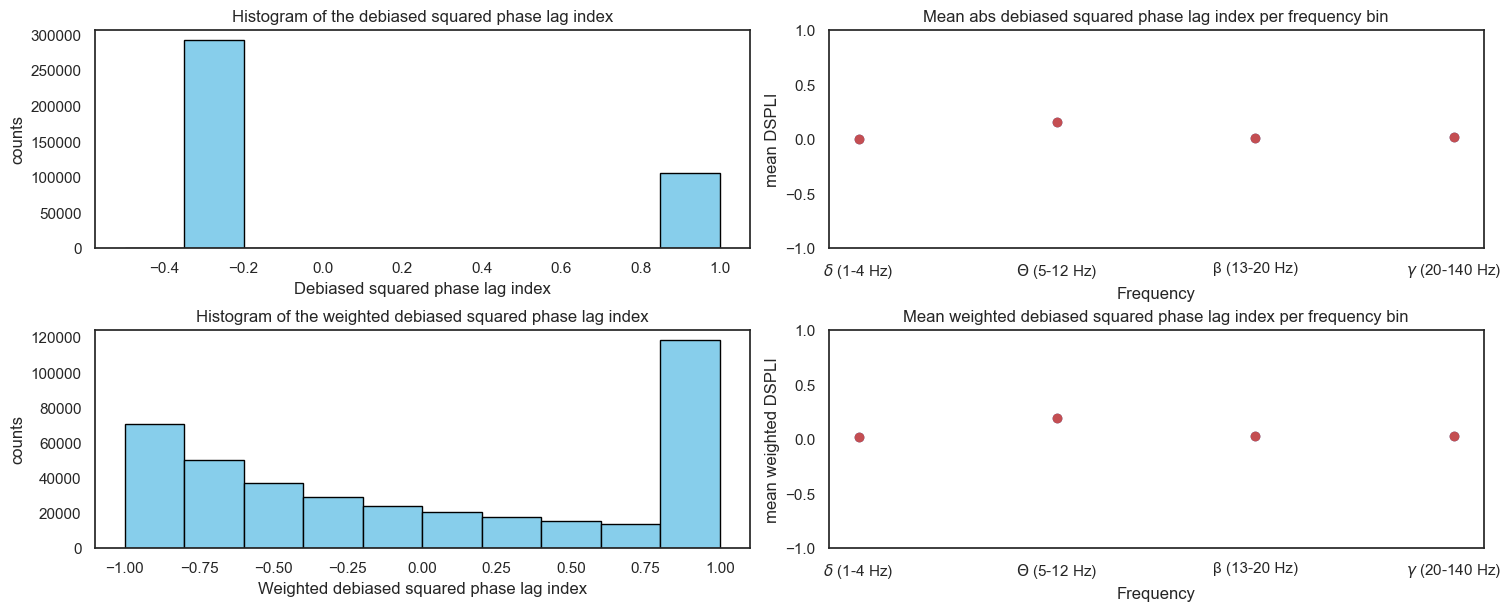

In [28]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6), constrained_layout=True)

axes[0,0].hist(dspli_set, bins=10, color='skyblue', edgecolor='black')
axes[0,0].set_xlabel('Debiased squared phase lag index')
axes[0,0].set_ylabel('counts')
axes[0,0].set_title('Histogram of the debiased squared phase lag index')

axes[1,0].hist(wdspli_set, bins=10, color='skyblue', edgecolor='black')
axes[1,0].set_xlabel('Weighted debiased squared phase lag index')
axes[1,0].set_ylabel('counts')
axes[1,0].set_title('Histogram of the weighted debiased squared phase lag index')

mean = binned_statistic(frequency_set, dspli_set, bins=[1, 5, 13, 20, 140], statistic='mean')
stdev = binned_statistic(frequency_set, dspli_set, bins=[1, 5, 13, 20, 140], statistic='std')
n = len(dspli_set)

bin_edges = mean.bin_edges
bin_means = mean.statistic
bin_stdev = stdev.statistic
error = bin_stdev/(np.sqrt(n))

freq_middle = [3, 8, 16, 80]

axes[0,1].scatter(frequency_type, bin_means)
axes[0,1].errorbar(frequency_type, bin_means, yerr=error, fmt="o", color="r")
axes[0,1].set_ylim(-1,1)
#axes[2].set_xlim(0,140)
axes[0,1].set_ylabel('mean DSPLI')
axes[0,1].set_xlabel('Frequency')
axes[0,1].set_title('Mean abs debiased squared phase lag index per frequency bin')

mean2 = binned_statistic(frequency_set2, wdspli_set, bins=[1, 5, 13, 20, 140], statistic='mean')
stdev2 = binned_statistic(frequency_set2, wdspli_set, bins=[1, 5, 13, 20, 140], statistic='std')

bin_edges2 = mean2.bin_edges
bin_means2 = mean2.statistic
bin_stdev2 = stdev2.statistic
error2 = bin_stdev2/(np.sqrt(n))

axes[1,1].scatter(frequency_type, bin_means2)
axes[1,1].errorbar(frequency_type, bin_means2, yerr=error2, fmt="o", color="r")
axes[1,1].set_ylim(-1,1)
#axes[2].set_xlim(0,140)
axes[1,1].set_ylabel('mean weighted DSPLI')
axes[1,1].set_xlabel('Frequency')
axes[1,1].set_title('Mean weighted debiased squared phase lag index per frequency bin')

for i in range(len(bin_means)):
    print('mean dspli:', bin_means[i], '+/-', error[i])

for i in range(len(bin_means)):
    print('mean wdspli:', bin_means2[i], '+/-', error2[i])
#revbinnedstars, edges, _ = binned_statistic(rev_count, stars, 'mean', bins=10)
#revbin = edges[:-1]
mean_dspli_tonic = bin_means
mean_wdspli_tonic = bin_means2
SEM_dspli_tonic = error
SEM_wdspli_tonic = error2

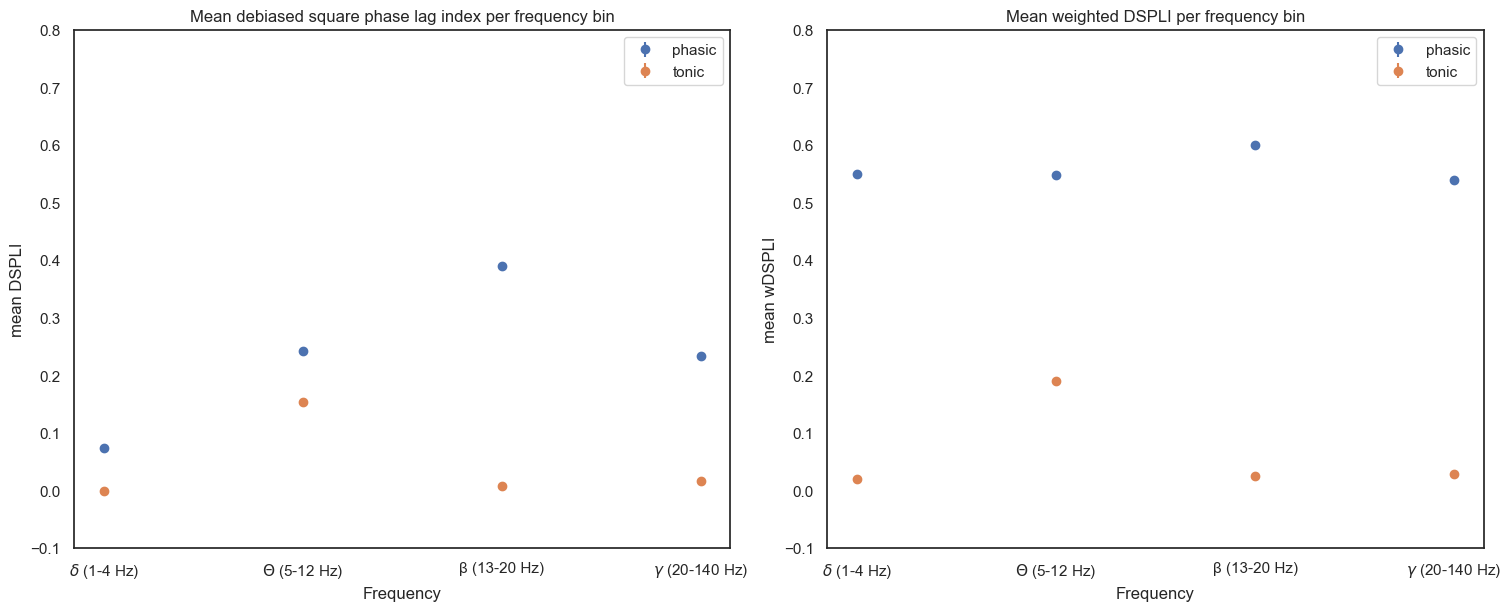

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), constrained_layout=True)
axes[0].errorbar(frequency_type, mean_dspli_phasic, yerr=SEM_dspli_phasic, fmt="o", label='phasic')
axes[0].errorbar(frequency_type, mean_dspli_tonic, yerr=SEM_dspli_tonic, fmt="o", label='tonic')
axes[0].set_ylim(-0.1,0.8)
#axes[2].set_xlim(0,140)
axes[0].set_ylabel('mean DSPLI')
axes[0].set_xlabel('Frequency')
axes[0].set_title('Mean debiased square phase lag index per frequency bin')
axes[0].legend()

axes[1].errorbar(frequency_type, mean_wdspli_phasic, yerr=SEM_wdspli_phasic, fmt="o", label='phasic')
axes[1].errorbar(frequency_type, mean_wdspli_tonic, yerr=SEM_wdspli_tonic, fmt="o", label='tonic')
axes[1].set_ylim(-0.1,0.8)
#axes[2].set_xlim(0,140)
axes[1].set_ylabel('mean wDSPLI')
axes[1].set_xlabel('Frequency')
axes[1].set_title('Mean weighted DSPLI per frequency bin')
plt.legend()

## Pairwise phase consistency

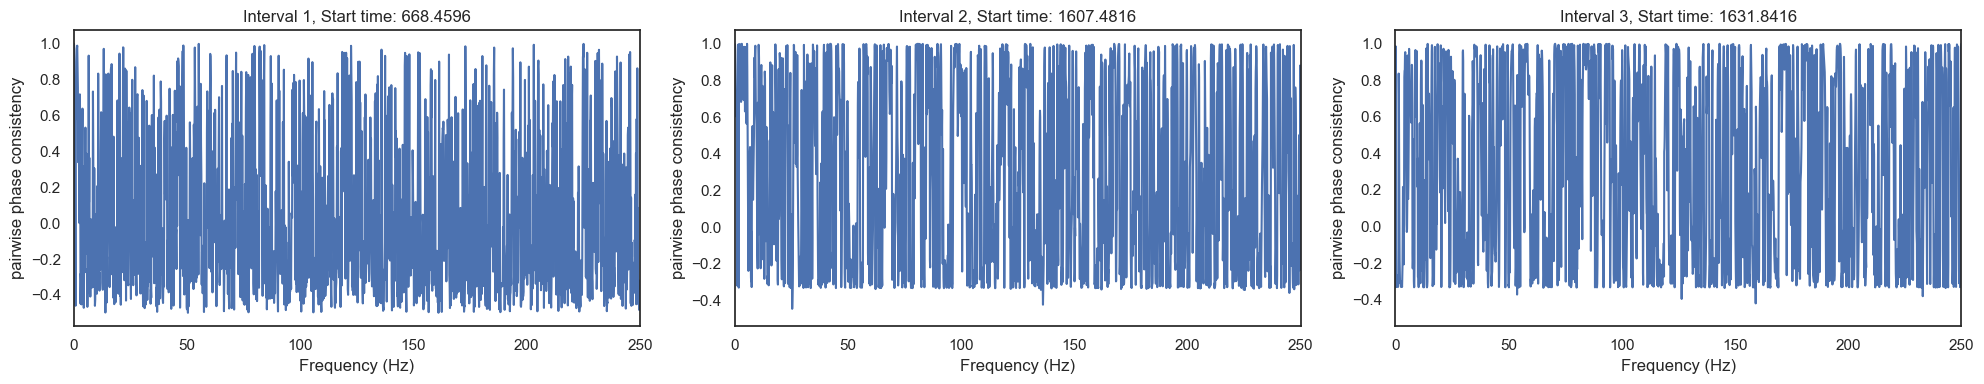

In [30]:
time_halfbandwidth_product = 2 #test value from example
sampling_frequency = 2500
frequency_set = []
ppc_set = []

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 4), constrained_layout=True)

for i in range(len(phasic_interval)):
    interval_low = find_nearest(t, phasic_interval[i,0])
    index_low = np.where(t == interval_low)[0]
    
    interval_high = find_nearest(t, phasic_interval[i,1])
    index_high = np.where(t == interval_high)[0]

    signal1 = (lfpHPC[index_low[0]:index_high[0]]).T
    signal1_padded = np.pad(signal1, pad_width = (highsize - len(signal1)), mode = 'constant', constant_values = 0)
    signal2 = (lfpPFC[index_low[0]:index_high[0]]).T
    signal2_padded = np.pad(signal2, pad_width = (highsize - len(signal2)), mode = 'constant', constant_values = 0)

    signal_tot = np.vstack((signal1_padded.T,signal2_padded.T)).T
    signal_tot.shape

    time = t[index_low[0]:index_high[0]]
    time_padded = np.pad(time, pad_width = (highsize - len(time)), mode = 'constant', constant_values = 0)

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    
    frequency_set = np.append(frequency_set,connectivity.frequencies)
    ppc_set = np.append(ppc_set, connectivity.pairwise_phase_consistency()[..., 0, 1].squeeze())
    
    axes[i].plot(
        connectivity.frequencies, connectivity.pairwise_phase_consistency()[..., 0, 1].squeeze(),
    )
    #axes[i].set_xlim((0, multitaper.nyquist_frequency))
    axes[i].set_xlim((0, 250))
    axes[i].set_title(f"Interval {i+1}, Start time: {phasic_interval[i,0]}")
    axes[i].set_xlabel('Frequency (Hz)')
    axes[i].set_ylabel('pairwise phase consistency')

fig.set_layout_engine(layout='tight')
fig.savefig("phasic_ppc_R1T4_HC.png")

mean ppc: 0.34061619347878985 +/- 0.002818785554683835
mean ppc: 0.2768953795088487 +/- 0.002403730391894741
mean ppc: 0.25113407554831 +/- 0.002386360944953022
mean ppc: 0.24566175172119656 +/- 0.0026332525514787763


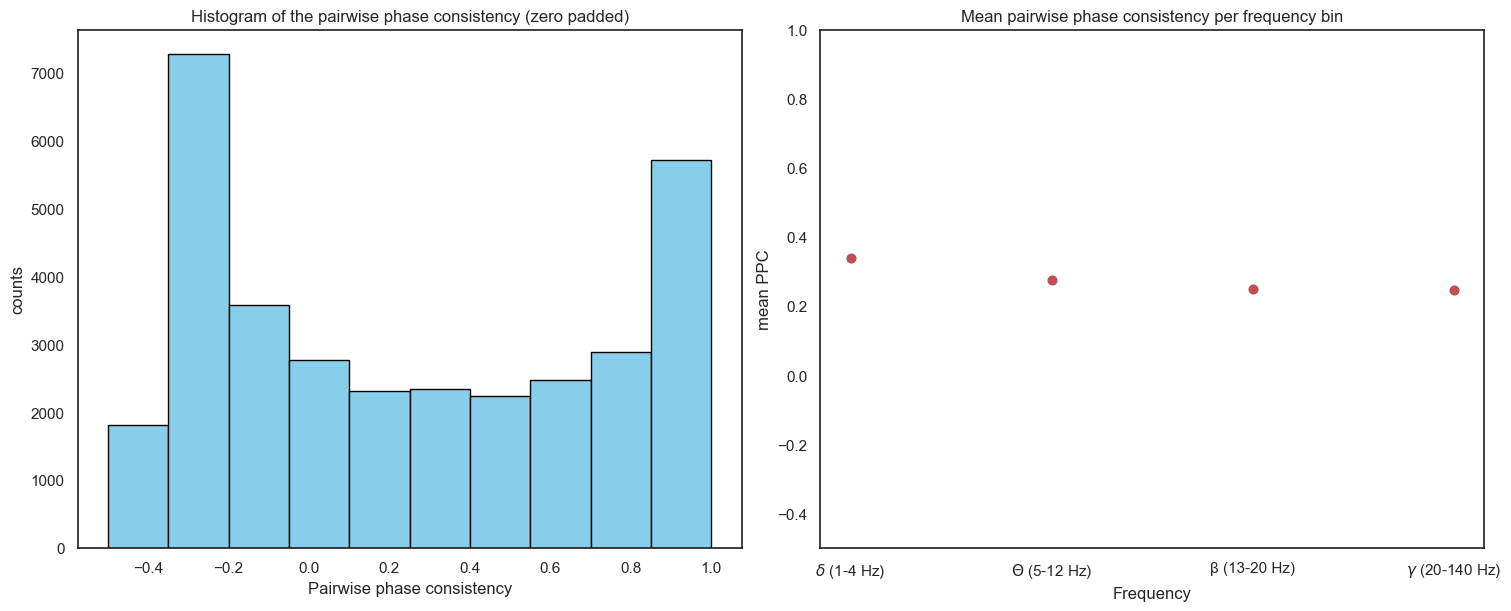

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), constrained_layout=True)

axes[0].hist(ppc_set, bins=10, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Pairwise phase consistency')
axes[0].set_ylabel('counts')
axes[0].set_title('Histogram of the pairwise phase consistency (zero padded)')


mean = binned_statistic(frequency_set, (ppc_set), bins=[1, 5, 13, 20, 140], statistic='mean')
stdev = binned_statistic(frequency_set, (ppc_set), bins=[1, 5, 13, 20, 140], statistic='std')
n = len(ppc_set)

bin_edges = mean.bin_edges
bin_means = mean.statistic
bin_stdev = stdev.statistic
error = bin_stdev/(np.sqrt(n))

freq_middle = [3, 8, 16, 80]

axes[1].scatter(frequency_type, bin_means)
axes[1].errorbar(frequency_type, bin_means, yerr=error, fmt="o", color="r")
axes[1].set_ylim(-0.5,1)
#axes[2].set_xlim(0,140)
axes[1].set_ylabel('mean PPC')
axes[1].set_xlabel('Frequency')
axes[1].set_title('Mean pairwise phase consistency per frequency bin')

for i in range(len(bin_means)):
    print('mean ppc:', bin_means[i], '+/-', error[i])
#revbinnedstars, edges, _ = binned_statistic(rev_count, stars, 'mean', bins=10)
#revbin = edges[:-1]

mean_ppc_phasic = bin_means
SEM_ppc_phasic = error

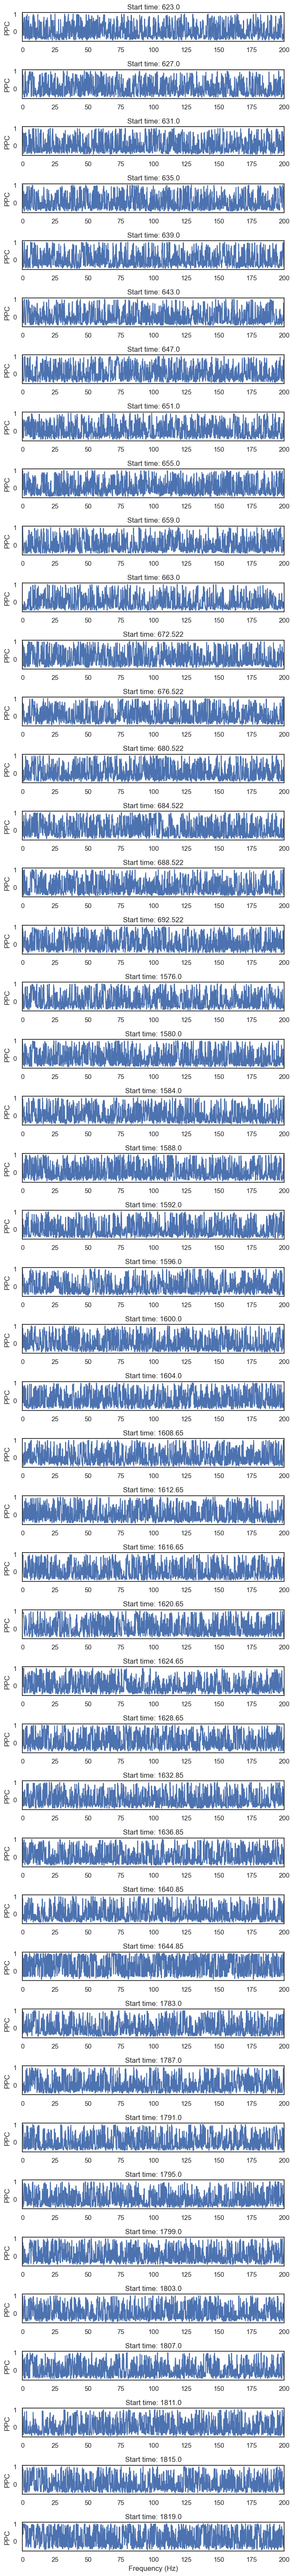

In [32]:
output_folder = "C:/Users/ejsev/Downloads/sleep scoring/outputs/Plots_OS_Basic"
time_halfbandwidth_product = 2 #test value from example
sampling_frequency = 2500
frequency_set = []
ppc_set = []

fig, axes = plt.subplots(nrows=len(tonic_time), ncols=1, figsize=(7, 60), constrained_layout=True)

for i in range(len(tonic_time)):
    tonic_interval_low = find_nearest(t, tonic_time[i,0])
    tonic_index_low = np.where(t == tonic_interval_low)[0]
    
    tonic_interval_high = find_nearest(t, tonic_time[i,1])
    tonic_index_high = np.where(t == tonic_interval_high)[0]

    signal1 = (lfpHPC[tonic_index_low[0]:tonic_index_high[0]]).T
    signal1_padded = np.pad(signal1, pad_width = (highsize - len(signal1)), mode = 'constant', constant_values = 0)
    signal2 = (lfpPFC[tonic_index_low[0]:tonic_index_high[0]]).T
    signal2_padded = np.pad(signal2, pad_width = (highsize - len(signal2)), mode = 'constant', constant_values = 0)

    signal_tot = np.vstack((signal1_padded.T,signal2_padded.T)).T
    signal_tot.shape

    time = t[index_low[0]:index_high[0]]
    time_padded = np.pad(time, pad_width = (highsize - len(time)), mode = 'constant', constant_values = 0)

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    
    frequency_set = np.append(frequency_set,connectivity.frequencies)
    ppc_set = np.append(ppc_set, connectivity.pairwise_phase_consistency()[..., 0, 1].squeeze())
    
    axes[i].plot(
        connectivity.frequencies, connectivity.pairwise_phase_consistency()[..., 0, 1].squeeze(),
    )
    #axes[i].set_xlim((0, multitaper.nyquist_frequency))
    axes[i].set_xlim((0, 200))
    #axes[i].set_title(f"Interval {i+1}, real COH")
    axes[i].set_title(f"Start time: {tonic_time[i,0]}")
    #axes[i].set_xlabel('Frequency (Hz)')
    axes[i].set_ylabel('PPC')

axes[len(tonic_time)-1].set_xlabel('Frequency (Hz)')

fig.set_layout_engine(layout='tight')
fig.savefig("tonic_ppc_R1T4_HC.png")

mean ppc: 0.05926989020979194 +/- 0.0006840463784346614
mean ppc: 0.125655173396696 +/- 0.0007284831117590855
mean ppc: 0.06218338169523799 +/- 0.0006889928635267428
mean ppc: 0.04198704295586035 +/- 0.0006737897529312892


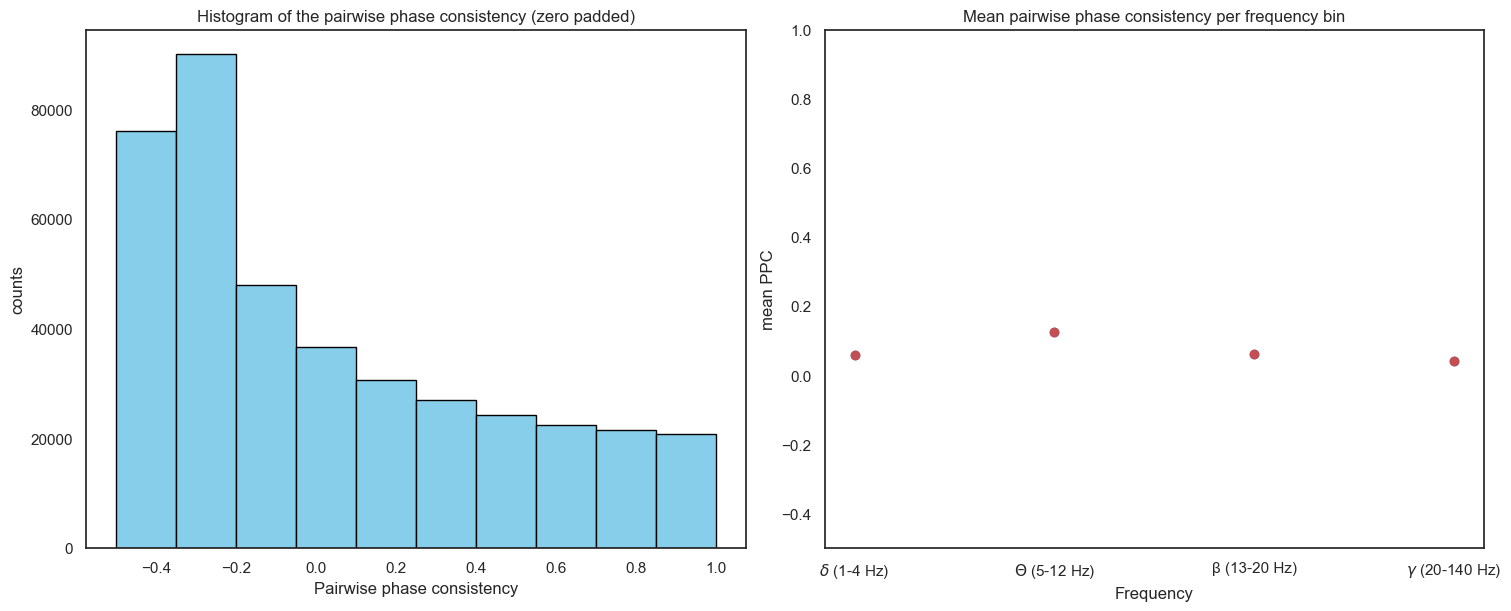

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), constrained_layout=True)

axes[0].hist(ppc_set, bins=10, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Pairwise phase consistency')
axes[0].set_ylabel('counts')
axes[0].set_title('Histogram of the pairwise phase consistency (zero padded)')


mean = binned_statistic(frequency_set, (ppc_set), bins=[1, 5, 13, 20, 140], statistic='mean')
stdev = binned_statistic(frequency_set, (ppc_set), bins=[1, 5, 13, 20, 140], statistic='std')
n = len(ppc_set)

bin_edges = mean.bin_edges
bin_means = mean.statistic
bin_stdev = stdev.statistic
error = bin_stdev/(np.sqrt(n))

freq_middle = [3, 8, 16, 80]

axes[1].scatter(frequency_type, bin_means)
axes[1].errorbar(frequency_type, bin_means, yerr=error, fmt="o", color="r")
axes[1].set_ylim(-0.5,1)
#axes[2].set_xlim(0,140)
axes[1].set_ylabel('mean PPC')
axes[1].set_xlabel('Frequency')
axes[1].set_title('Mean pairwise phase consistency per frequency bin')

for i in range(len(bin_means)):
    print('mean ppc:', bin_means[i], '+/-', error[i])
#revbinnedstars, edges, _ = binned_statistic(rev_count, stars, 'mean', bins=10)
#revbin = edges[:-1]
mean_ppc_tonic = bin_means
SEM_ppc_tonic = error

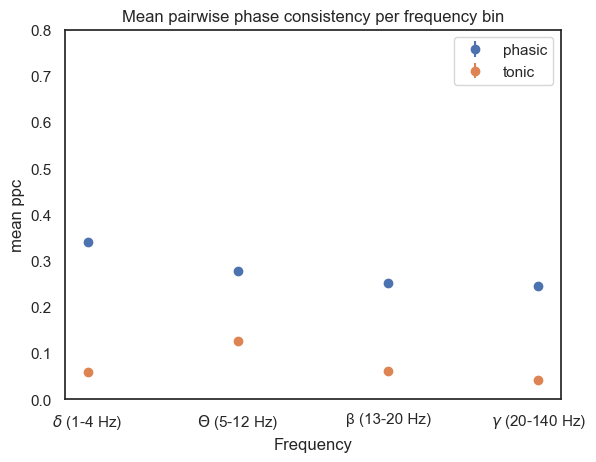

In [34]:
plt.errorbar(frequency_type, mean_ppc_phasic, yerr=SEM_ppc_phasic, fmt="o", label='phasic')
plt.errorbar(frequency_type, mean_ppc_tonic, yerr=SEM_ppc_tonic, fmt="o", label='tonic')
plt.ylim(0,0.8)
plt.ylabel('mean ppc')
plt.xlabel('Frequency')
plt.title('Mean pairwise phase consistency per frequency bin')
plt.legend()

## Table

In [35]:
mean_coh = np.hstack((mean_coh_phasic, mean_coh_tonic))
mean_icoh = np.hstack((mean_icoh_phasic, mean_icoh_tonic))
mean_pli = np.hstack((mean_pli_phasic, mean_pli_tonic))
mean_wpli = np.hstack((mean_wpli_phasic, mean_wpli_tonic))
mean_dspli = np.hstack((mean_dspli_phasic, mean_dspli_tonic))
mean_wdspli = np.hstack((mean_wdspli_phasic, mean_wdspli_tonic))
mean_ppc = np.hstack((mean_ppc_phasic, mean_ppc_tonic))

SEM_coh = np.hstack((SEM_coh_phasic, SEM_coh_tonic))
SEM_icoh = np.hstack((SEM_icoh_phasic, SEM_icoh_tonic))
SEM_pli = np.hstack((SEM_pli_phasic, SEM_pli_tonic))
SEM_wpli = np.hstack((SEM_wpli_phasic, SEM_wpli_tonic))
sem_dspli = np.hstack((SEM_dspli_phasic, SEM_dspli_tonic))
sem_wdspli = np.hstack((SEM_wdspli_phasic, SEM_wdspli_tonic))
SEM_ppc = np.hstack((SEM_ppc_phasic, SEM_ppc_tonic))

In [36]:
rows = []
for i in range(8):
    rows.append({
                    'COH': mean_coh[i],
                    'SE COH': SEM_coh[i],
                    'iCOH': mean_icoh[i],
                    'SE iCOH': SEM_icoh[i],
                    'PLI': mean_pli[i],
                    'SE PLI': SEM_pli[i],
                    'wPLI': mean_wpli[i],
                    'SE wPLI': SEM_wpli[i],
                    'DSPLI': mean_dspli[i],
                    'SE DSPLI': sem_dspli[i],
                    'wDSPLI': mean_wdspli[i],
                    'SE wDSPLI': sem_wdspli[i],
                    'PPC': mean_ppc[i],
                    'SE PPC': SEM_ppc[i]
                })
df = pd.DataFrame(rows, index = ["phasic delta", "phasic theta", "phasic theta-gamma", "phasic gamma", "tonic delta", "tonic theta", "tonic theta-gamma", "tonic gamma"])
df.to_csv('C:/Users/ejsev/Downloads/sleep scoring/table_connectivity_R1T4_HC.csv', index=True)
df

COH    SE COH      iCOH   SE iCOH       PLI  \
phasic delta        0.630909  0.001777  0.433914  0.001367 -0.179012   
phasic theta        0.559103  0.001888  0.507790  0.001607  0.361502   
phasic theta-gamma  0.598975  0.001870  0.537987  0.001603 -0.042553   
phasic gamma        0.585473  0.001852  0.507398  0.001618  0.112980   
tonic delta         0.228041  0.000375  0.352281  0.000373  0.030113   
tonic theta         0.265642  0.000400  0.434124  0.000426  0.248528   
tonic theta-gamma   0.230843  0.000383  0.358023  0.000375  0.049543   
tonic gamma         0.216006  0.000361  0.357758  0.000374 -0.000515   

                      SE PLI      wPLI   SE wPLI     DSPLI  SE DSPLI  \
phasic delta        0.003239 -0.183176  0.004749  0.074074  0.003359   
phasic theta        0.003301  0.416032  0.004268  0.242567  0.003612   
phasic theta-gamma  0.004207 -0.070983  0.004881  0.390071  0.003633   
phasic gamma        0.003777  0.140458  0.004748  0.234476  0.003606   
tonic delta         0.000914  0.054566  0.001140 -0.000262  0.000915   
tonic theta         0.000969  0.331382  0.001128  0.152990  0.001018   
tonic theta-gamma   0.000919  0.096924  0.001146  0.007334  0.000922   
tonic gamma         0.000931 -0.000673  0.001159  0.017268  0.000931   

                      wDSPLI  SE wDSPLI       PPC    SE PPC  
phasic delta        0.550344   0.003069  0.340616  0.002819  
phasic theta        0.547211   0.003370  0.276895  0.002404  
phasic theta-gamma  0.599523   0.003389  0.251134  0.002386  
phasic gamma        0.539220   0.003439  0.245662  0.002633  
tonic delta         0.020056   0.001170  0.059270  0.000684  
tonic theta         0.189610   0.001215  0.125655  0.000728  
tonic theta-gamma   0.025315   0.001182  0.062183  0.000689  
tonic gamma         0.028476   0.001188  0.041987  0.000674